# Module 4 - Reducing unfairness in learning algorithm applications 


### Assignment overview

In this assignment, you are tasked to create a classifer to predict the estimated income of individuals in the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). This dataset is known to be biased towards certain groups. You will try some strategies to create a more fair classifier.

For this assignment, it is possible to work in **groups of up to 2 students**. Read the instructions carefully, as they may assign tasks to specific students.

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Jingyuan Liu (S.N. 69763183)
- Student 2: Nicholas Tam (S.N. 45695970)


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Discuss the consequences of erroneous (biased) data on the training of learning algorithms and how it impacts its end users  
2. Discuss potential ethical implications in errors in feature selection, model selection 
3. Describe strategies for reducing algorithmic bias 
4. Apply strategies to reduce unfairness in a predictive model trained on an unbalanced dataset 
5. Describe advantages and limitations of the strategies used to reduce unfairness in predictive models

### Libraries

Here are some libraries you will need for this assignment. `imblearn` and `aif360` are new ones, you can install it by running the cell below. Comment out this line after one execution:

In [1]:
# !pip install imblearn 
# !pip install aif360 

# !conda install imblearn -n DSCI430
# !conda install aif360 -n DSCI430

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.datasets import BinaryLabelDataset

import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Dataset

The dataset you will use for this assignment is the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). You may visit the source page for more information about this dataset.

The dataset includes 15 columns: 14 of them are demographics and other features to describe a person, and one (the target variable), is their income. The income variable is binary and has the two possible values `<=50K` or `>50K`.

Let's start by importing the dataset and taking a look (you are free to add other lines if you want more details):

In [3]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Unfortunately, this dataset is notoriously biased in the association between income and other demographic information, such as race and gender. Let's see how.

#### Question 1 
Create the following 3 bar charts:
- A global bar chart of the target variable
- A bar chart of the target variable divided by gender
- A bar chart of the target variable divided by race

Comment on the results. Is the target variable balanced? Is the target variable balanced across protected groups?

income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

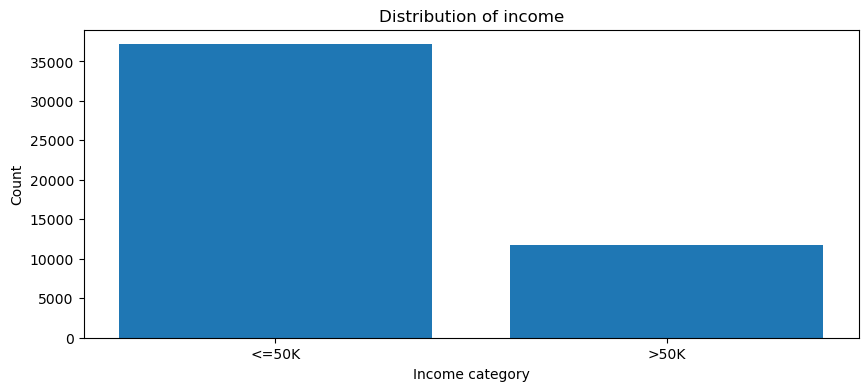

In [4]:
# Your answer here

display(df["income"].value_counts(normalize=True).sort_index())

plt.figure(figsize=(10,4))
frame = df["income"].astype("string").value_counts().sort_index()
plt.bar(frame.index, frame)
plt.xlabel("Income category")
plt.ylabel("Count")
plt.title("Distribution of income") 
plt.show()

<span style="color:blue">Across the entire dataset, the target variable `income` is not balanced, with 0.760718 of the samples having `income == "<=50K"`, and 0.239282 of the samples having `income == ">50K"`; we have much more individuals with `income == "<=50K"` than people with `income == ">50K"` in the dataset. As a result, the model may have biased predictive results in favor of the more frequent class of the target variable.</span>

<Figure size 1000x400 with 0 Axes>

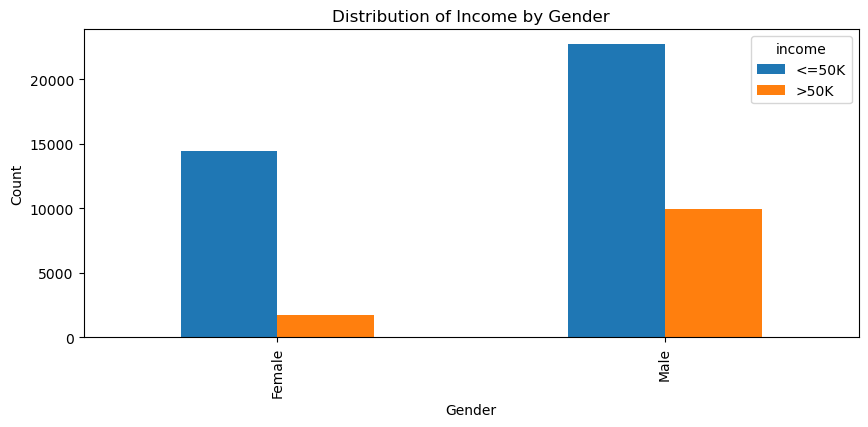

'Female'

income
<=50K    0.890749
>50K     0.109251
Name: proportion, dtype: float64

'Male'

income
<=50K    0.696233
>50K     0.303767
Name: proportion, dtype: float64

In [5]:
genders = df["gender"].astype("string").value_counts().sort_index().index

# for gen in genders: 
#     data = df[df["gender"] == gen]
#     print("Distribution of income for " + gen.lower())
#     display(data["income"].value_counts(normalize=True).sort_index())

#     plt.figure(figsize=(10,4))
#     frame = data["income"].astype("string")
#     f_cats = frame.value_counts().sort_index()
#     plt.bar(f_cats.index, f_cats)
#     plt.xlabel(gen)
#     plt.ylabel("Count")
#     plt.title("Distribution of income for " + gen.lower()) 
#     plt.show() 

grouped_data_gender = df.groupby(["gender", "income"]).size().unstack()
plt.figure(figsize=(10, 4))
grouped_data_gender.plot(kind="bar", stacked=False, figsize=(10, 4))
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of Income by Gender")
plt.show()

for gen in genders: 
    data = df[df["gender"] == gen]
    display(gen,data["income"].value_counts(normalize=True))

<span style="color:blue">The target variable `income` is not balanced across each `gender` groups, nor are the distributions of each `income` category equal across each level of `gender`. For instance, the proportion of `income == "<=50K"` samples is 0.890749 among female individuals and only 0.696233 among male individuals. This runs the risk of differential treatment and classification of `income` between categories of protected characteristics and increases the predictive bias and the possibility of unfairness against certain groups under protected characteristics.</span>

<Figure size 1000x800 with 0 Axes>

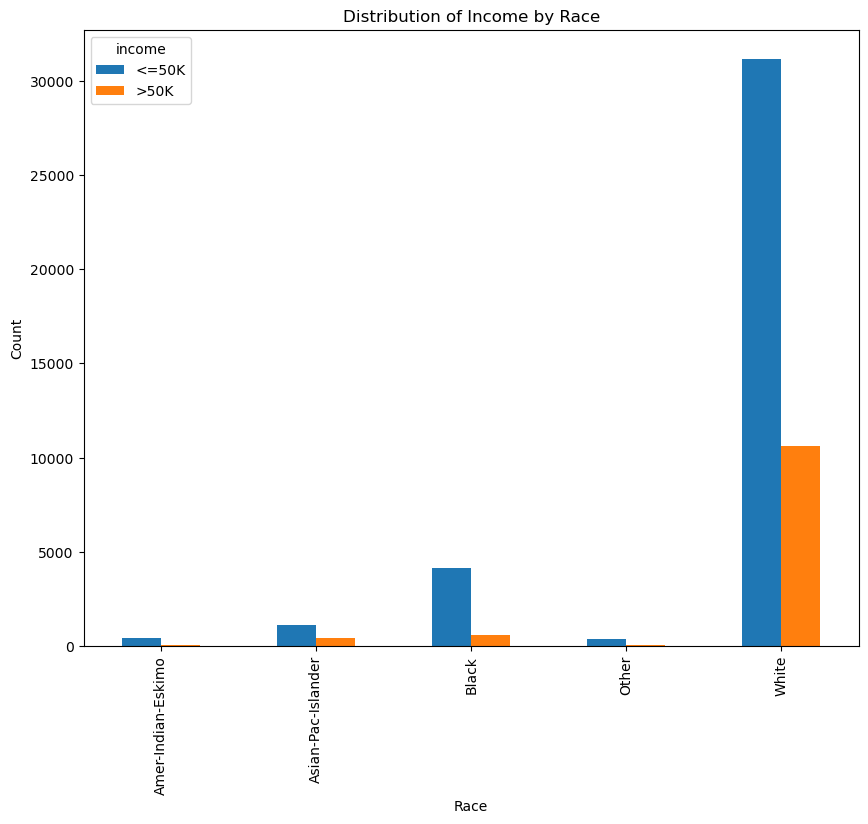

'Amer-Indian-Eskimo'

income
<=50K    0.882979
>50K     0.117021
Name: proportion, dtype: float64

'Asian-Pac-Islander'

income
<=50K    0.730744
>50K     0.269256
Name: proportion, dtype: float64

'Black'

income
<=50K    0.879189
>50K     0.120811
Name: proportion, dtype: float64

'Other'

income
<=50K    0.876847
>50K     0.123153
Name: proportion, dtype: float64

'White'

income
<=50K    0.746013
>50K     0.253987
Name: proportion, dtype: float64

In [6]:
races = df["race"].astype("string").value_counts().sort_index().index

# for gen in races: 
#     data = df[df["race"] == gen]
#     print("Distribution of income for " + gen.lower())
#     display(data["income"].value_counts(normalize=True).sort_index())

#     plt.figure(figsize=(10,4))
#     frame = data["income"].astype("string")
#     f_cats = frame.value_counts().sort_index()
#     plt.bar(f_cats.index, f_cats)
#     plt.xlabel(gen)
#     plt.ylabel("Count")
#     plt.title("Distribution of income for " + gen.lower()) 
#     plt.show() 

grouped_data_race = df.groupby(["race", "income"]).size().unstack()
plt.figure(figsize=(10, 8))
grouped_data_race.plot(kind="bar", stacked=False, figsize=(10, 8))
plt.xlabel("Race")
plt.ylabel("Count")
plt.title("Distribution of Income by Race")
plt.show()

for race in races: 
    data = df[df["race"] == race]
    display(race,data["income"].value_counts(normalize=True))

<span style="color:blue">The target variable `income` is not balanced across each `race` groups either, nor are the distributions of each `income` category equal across each level of `race`. For instance, the proportion of `income == "<=50K"` samples is 0.882979 among amer-indian-eskimo individuals and 0.746013 among white individuals. This runs the risk of differential treatment and classification of `income` between categories of protected characteristics and increases the predictive bias and the possibility of unfairness against certain groups under protected characteristics.</span>

### A biased classifier

We can expect that a classifier trained on this kind of data will show some problematic behaviors when assigning an individual to a predicted income level. Let's visualize this using a random forest classifier.

In [7]:
# STEP 1
# Run this cell create training and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

In [8]:
test_df.shape

(14653, 15)

In [9]:
# STEP 2
# Run this cell to do the necessary dataset preprocessing (encoding of categorical features).
# Note that, since we are using a tree based classifier, we don't need to scale the 
# numerical features.

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ct.fit_transform(X_train).toarray()

column_names = list(
    ct.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

X_test_transformed = ct.transform(X_test).toarray()

In [10]:
# You may use this lines to check the result
pd.DataFrame(X_train_transformed, columns=column_names).head()
# pd.DataFrame(X_test_transformed, columns=column_names)

,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,...,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,18.0,152508.0,7.0,0.0,0.0,20.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,55.0,136819.0,9.0,0.0,0.0,40.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,43.0,191149.0,9.0,0.0,0.0,40.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,44.0,241851.0,11.0,4386.0,0.0,40.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,41.0,369781.0,9.0,0.0,0.0,55.0


In [11]:
# STEP 3
# Run this cell to train a random forest classifer. The hyperparameters have been pre-selected

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_transformed, y_train)

How good is this classifier? Let's check its accuracy, by running the cells below:

In [12]:
clf.score(X_train_transformed, y_train)

0.9064318932990143

In [13]:
clf.score(X_test_transformed, y_test)

0.8624172524397734

Finally, let's see what features are considered important by the classifier.

<Axes: >

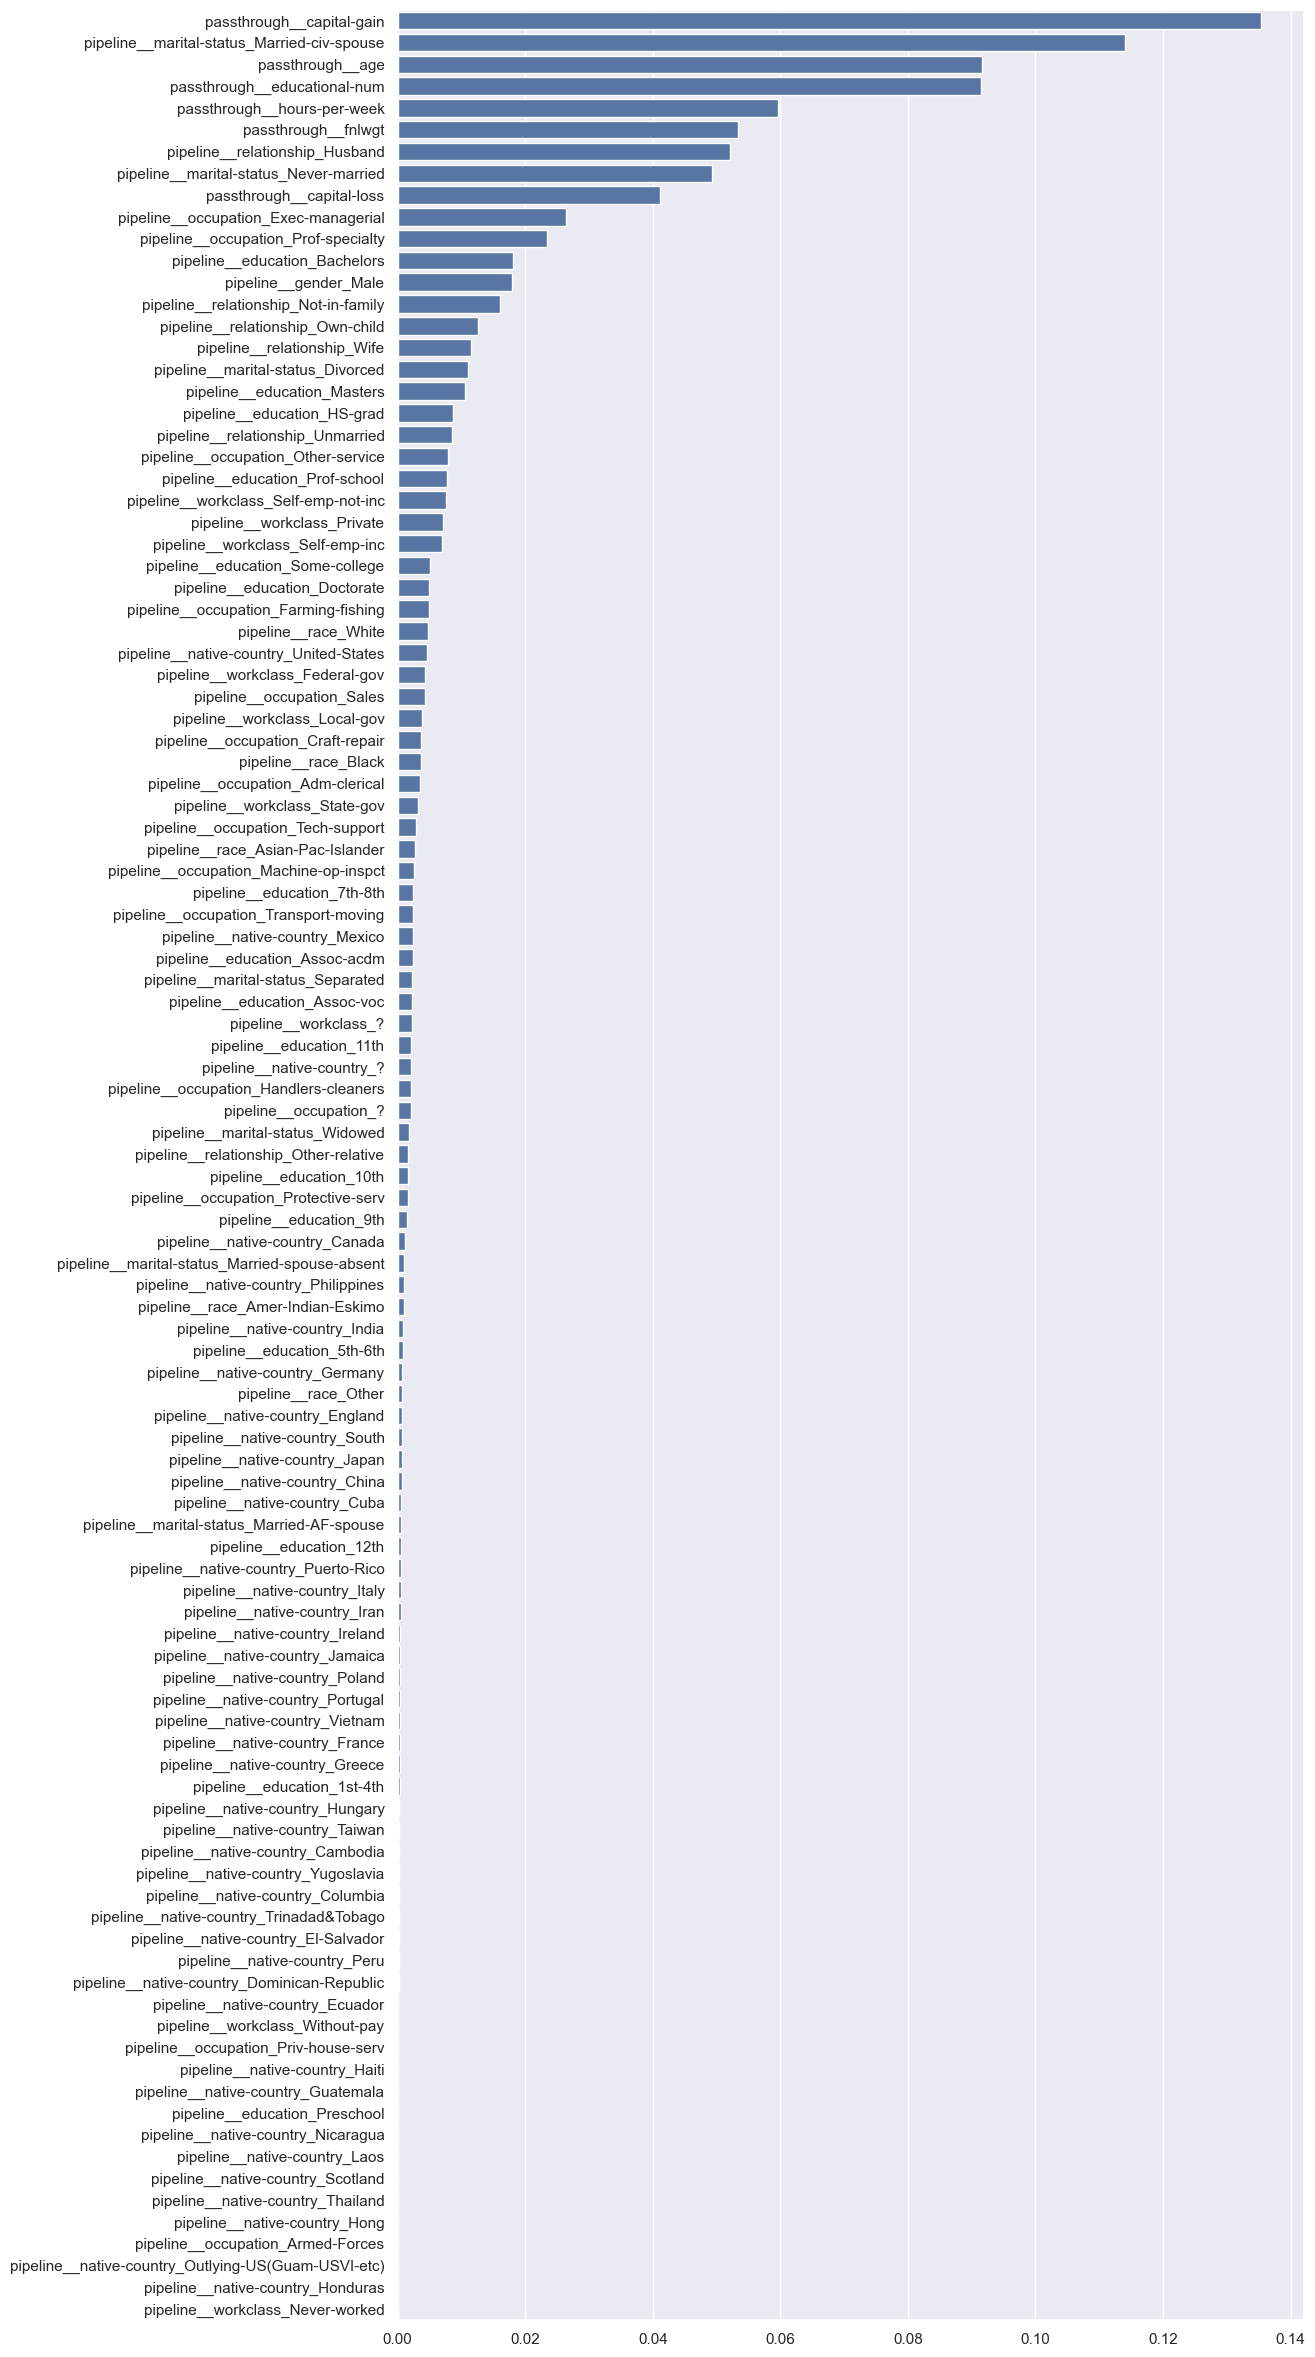

In [14]:
import seaborn as sns

feature_importances = clf.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = ct.get_feature_names_out()[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

In [15]:
sorted_feature_names

array(['passthrough__capital-gain',
       'pipeline__marital-status_Married-civ-spouse', 'passthrough__age',
       'passthrough__educational-num', 'passthrough__hours-per-week',
       'passthrough__fnlwgt', 'pipeline__relationship_Husband',
       'pipeline__marital-status_Never-married',
       'passthrough__capital-loss',
       'pipeline__occupation_Exec-managerial',
       'pipeline__occupation_Prof-specialty',
       'pipeline__education_Bachelors', 'pipeline__gender_Male',
       'pipeline__relationship_Not-in-family',
       'pipeline__relationship_Own-child', 'pipeline__relationship_Wife',
       'pipeline__marital-status_Divorced', 'pipeline__education_Masters',
       'pipeline__education_HS-grad', 'pipeline__relationship_Unmarried',
       'pipeline__occupation_Other-service',
       'pipeline__education_Prof-school',
       'pipeline__workclass_Self-emp-not-inc',
       'pipeline__workclass_Private', 'pipeline__workclass_Self-emp-inc',
       'pipeline__education_Some-co

#### Question 2
What are the most important features for this classifier? Do they include protected characteristics, such as race or gender?

<span style="color:blue">Based on the figure above, the top most important features for the classifier with scores greater than approximately 0.01 are `passthrough__capital-gain`, `pipeline__marital-status_Married-civ-spouse`, `passthrough__age`, `passthrough__educational-num`, `passthrough__hours-per-week`, `passthrough__fnlwgt`, `pipeline__relationship_Husband`, `pipeline__marital_status_Never-married`, `passthrough__capital-loss`, `passthrough__occupation_Exec-managerial`, `pipeline__occupation_Prof-specialty`, `pipeline__education_Bachelors`, `pipeline__gender_Male`, `pipeline__relationship_Not-in-family`, `pipeline__relationship_Own-child', 'pipeline__relationship_Wife`, `pipeline__marital-status_Divorced`, and `pipeline__education_Masters`. There are many protected characteristics among the most important features, most notably `pipeline__marital-status_Married-civ-spouse`, `passthrough__age`, `pipeline__relationship_Husband`, and `pipeline__marital_status_Never-married`, `pipeline__gender_Male`, `pipeline__relationship_Not-in-family`, `pipeline__relationship_Own-child', 'pipeline__relationship_Wife`, and `pipeline__marital-status_Divorced`. These protected characteristics belong to features such as `marital status`, `age`, `relationship`, `gender`, and etc. </span>

#### Question 3

From Assignment 3, we have learned that a classifier may perform well in terms of accuracy, but being unfair to protected groups in the dataset. Use what you have learned in Assignment 3 and **evaluate this classifier for fairness in treating the two gender groups included in this dataset.** In particular, do the following: 

- Compute the 6 fairness metrics and the Average Distance from the Reference on training and test sets. You may reuse portions of code you have included in Assignment 3.
- Comment on the results, providing an interpretation for each computed metric; how different is the treatment of the two groups? Is one (or more) of the metrics particularly concerning?

Here is a recap of the fairness metrics:
1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

In [16]:
# Your answer here (you may add more cells)
# Add as many cells as needed to compute the required metrics for every classifier. You may
# also add markdown cells if you want to add comments or notes about your results.

# Splitting datasets by gender
train_df_m = train_df[train_df["gender"] == "Male"]
train_df_f = train_df[train_df["gender"] == "Female"]
test_df_m = test_df[test_df["gender"] == "Male"]
test_df_f = test_df[test_df["gender"] == "Female"]
# train_df_m.head()

# Creating training and test sets and separating features and target
X_train_m, y_train_m = (
    train_df_m.drop(columns=["income"]),
    train_df_m["income"],
)
X_test_m, y_test_m = (
    test_df_m.drop(columns=["income"]),
    test_df_m["income"],
)
X_train_f, y_train_f = (
    train_df_f.drop(columns=["income"]),
    train_df_f["income"],
)
X_test_f, y_test_f = (
    test_df_f.drop(columns=["income"]),
    test_df_f["income"],
)

# xsets = [X_train_m, X_test_m, X_train_f, X_test_f]
# ysets = [y_train_m, y_test_m, y_train_f, y_test_f]

# Do not need to refit due to both ultimately training on the same set as a whole
X_train_transformed_m = pd.DataFrame(ct.transform(X_train_m).toarray(), columns=column_names)
X_train_transformed_f = pd.DataFrame(ct.transform(X_train_f).toarray(), columns=column_names)

X_test_transformed_m = pd.DataFrame(ct.transform(X_test_m).toarray(), columns=column_names)
X_test_transformed_f = pd.DataFrame(ct.transform(X_test_f).toarray(), columns=column_names)

In [17]:
fairness_mets = {
    "model": [],
    "PPRD": [],
    "PPGRD": [],
    "FDRD": [],
    "FPRD": [],
    "FORD": [],
    "FNRD": [],
    # "PPRD_dfr": [],
    # "PPGRD_dfr": [],
    # "FDRD_dfr": [],
    # "FPRD_dfr": [],
    # "FORD_dfr": [],
    # "FNRD_dfr": [],
    "adfr": [],
}

In [18]:
# confusion_matrix(y_m, model.predict(X_m))

In [19]:
# https://datascience.stackexchange.com/questions/28493/confusion-matrix-get-items-fp-fn-tp-tn-python

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def fairness_metrics(modelname, X_m_pred, y_m, X_f_pred, y_f, name):
# def fairness_metrics(modelname, model, X_m, y_m, X_f, y_f, name):
    # cm_m = confusion_matrix(y_m, model.predict(X_m))
    # cm_f = confusion_matrix(y_f, model.predict(X_f))
    cm_m = confusion_matrix(y_m, X_m_pred)
    cm_f = confusion_matrix(y_f, X_f_pred)
    
    # TP_m = cm_m[0][0] 
    # FP_m = cm_m[0][1] 
    # FN_m = cm_m[1][0] 
    # TN_m = cm_m[1][1] 

    # TP_f = cm_f[0][0] 
    # FP_f = cm_f[0][1] 
    # FN_f = cm_f[1][0] 
    # TN_f = cm_f[1][1] 

    TP_m = cm_m[1][1] 
    FP_m = cm_m[0][1] 
    FN_m = cm_m[1][0] 
    TN_m = cm_m[0][0] 

    TP_f = cm_f[1][1] 
    FP_f = cm_f[0][1] 
    FN_f = cm_f[1][0] 
    TN_f = cm_f[0][0] 

    PPRD = (TP_f + FP_f)/(TP_m + FP_m)
    PPGRD = ((TP_f + FP_f)/(TP_f + FP_f + FN_f + TN_f))/((TP_m + FP_m)/(TP_m + FP_m + FN_m + TN_m))
    FDRD = (FP_f/(TP_f + FP_f))/(FP_m/(TP_m + FP_m))
    FPRD = (FP_f/(TN_f + FP_f))/(FP_m/(TN_m + FP_m))
    FORD = (FN_f/(TN_f + FN_f))/(FN_m/(TN_m + FN_m))
    FNRD = (FN_f/(TP_f + FN_f))/(FN_m/(TP_m + FN_m))

    PPRD_adfr = abs(PPRD - 1)
    PPGRD_adfr = abs(PPGRD - 1)
    FDRD_adfr = abs(FDRD - 1)
    FPRD_adfr = abs(FPRD - 1)
    FORD_adfr = abs(FORD - 1)
    FNRD_adfr = abs(FNRD - 1)
    adfr = np.mean([PPRD_adfr, PPGRD_adfr, FDRD_adfr, FPRD_adfr, FORD_adfr, FNRD_adfr])

    fairness_mets["model"].append(str(modelname) + " (" + str(name) + ")")
    fairness_mets["PPRD"].append(PPRD)
    fairness_mets["PPGRD"].append(PPGRD)
    fairness_mets["FDRD"].append(FDRD)
    fairness_mets["FPRD"].append(FPRD)
    fairness_mets["FORD"].append(FORD)
    fairness_mets["FNRD"].append(FNRD)
    # fairness_mets["PPRD_adfr"].append(PPRD_adfr)
    # fairness_mets["PPGRD_adfr"].append(PPGRD_adfr)
    # fairness_mets["FDRD_adfr"].append(FDRD_adfr)
    # fairness_mets["FPRD_adfr"].append(FPRD_adfr)
    # fairness_mets["FORD_adfr"].append(FORD_adfr)
    # fairness_mets["FNRD_adfr"].append(FNRD_adfr)
    fairness_mets["adfr"].append(adfr)

In [20]:
display(train_df["gender"].value_counts(normalize=False).sort_index().sort_index())
display(test_df["gender"].value_counts(normalize=False).sort_index().sort_index())

# fairness_metrics("Random Forest", clf, X_train_transformed_m, y_train_m, X_train_transformed_f, y_train_f, "Training")
# fairness_metrics("Random Forest", clf, X_test_transformed_m, y_test_m, X_test_transformed_f, y_test_f, "Testing")
fairness_metrics("Random Forest", clf.predict(X_train_transformed_m), y_train_m, clf.predict(X_train_transformed_f), y_train_f, "Training")
fairness_metrics("Random Forest", clf.predict(X_test_transformed_m), y_test_m, clf.predict(X_test_transformed_f), y_test_f, "Testing")

fairness_mets_df = pd.DataFrame(fairness_mets)
fairness_mets_df = fairness_mets_df.set_index(["model"])
fairness_mets_df

gender
Female    11323
Male      22866
Name: count, dtype: int64

gender
Female    4869
Male      9784
Name: count, dtype: int64

,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,adfr
model,,,,,,,
Random Forest (Training),0.175265,0.353936,0.389925,0.107931,0.255968,0.852545,0.644072
Random Forest (Testing),0.143736,0.288830,0.837058,0.188731,0.351694,1.211745,0.566949


<span style="color:blue">The model exhibits extreme amounts of bias against female individuals, where every fairness metric except `FNRD` on the testing set is less than 1, indicate bias against female individuals. Most notably, the `FPRD` metric for the training and testing sets provides values of 0.107931 and 0.188731 respectively, indicating an extremely high false positive rate for male individuals compared to female individuals. The `FORD` for the training and testing sets provides values of 0.255968 and 0.351694 respectively, indicating an extremely high ratio of false negatives to predicted negatives for male individuals compared to female individuals. The value of `adfr` is relatively high, indicating the classifier is relatively unfair.</span>
#### <span style="color:purple"> Refined answer:</span>
<span style="color:purple">The model exhibits extreme amounts of bias against female individuals, where every fairness metric on the testing set significantly deviates from the base value of 1, most of which indicate bias against female individuals. Most notably, the `FPRD` metric for the training and testing sets provides values of 0.107931 and 0.188731 respectively, indicating an extremely high false positive rate for male individuals compared to female individuals. The `FORD` for the training and testing sets provides values of 0.255968 and 0.351694 respectively, indicating an extremely high ratio of false negatives to predicted negatives for male individuals compared to female individuals. However, given the significantly greater `FNRD` value on the testing set, it is possible that there may be very few false negatives compared to the total actual positives, so `FORD` may be small due to there being generally more negative predictions for women than men. The value of `adfr` is relatively high, indicating the classifier is relatively unfair.</span>

## Debiasing techniques: dropping protected characteristics

A first idea to fix this issue could be dropping the protected characteristics from our dataset before training the classifier. Let's try this out and see if there is any improvement.

#### Question 4
1. Drop race, gender and native country from training and test set (we are focusing on gender but we will drop race and native country for good measure).
2. Transform the cleaned dataset using one-hot encoding.
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous one. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Note that, to compare fairness, you will need to have a way to identify the gender of each sample, even though you are not using this feature for classification.
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the first one?

**Hint:** steps 2, 3 and 5 can be completed by tweaking the starting code given at the beginning of this assignment. Ask a TA or instructor if you need help in doing that.

In [21]:
# Your answer here (you may add more cells)
# Step 1 
X_train_new = X_train.drop(columns = ["race", "gender", "native-country"])
X_test_new = X_test.drop(columns = ["race", "gender", "native-country"])
# X_train_new

In [22]:
# Step 2
categorical_feats_new = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     ]  # Apply one-hot encoding
passthrough_feats_new = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct_new = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats_new,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats_new)  # no transformations on numerical features
)

X_train_transformed_new = ct_new.fit_transform(X_train_new).toarray()

column_names_new = list(
    ct_new.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats_new
    )
) + passthrough_feats_new

X_test_transformed_new = ct_new.transform(X_test_new).toarray()

X_train_transformed_new_df = pd.DataFrame(X_train_transformed_new, columns=column_names_new)
X_test_transformed_new_df = pd.DataFrame(X_test_transformed_new, columns=column_names_new)

In [23]:
# Step 3
clf_new = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_transformed_new, y_train)

In [24]:
# Step 4.1 
print("Training accuracy: " + str(clf.score(X_train_transformed, y_train)))
print("Testing accuracy: " + str(clf.score(X_test_transformed, y_test)))
print("Training accuracy (New): " + str(clf_new.score(X_train_transformed_new, y_train)))
print("Testing accuracy (New): " + str(clf_new.score(X_test_transformed_new, y_test)))

Training accuracy: 0.9064318932990143
Testing accuracy: 0.8624172524397734
Training accuracy (New): 0.9185410512153032
Testing accuracy (New): 0.860301644714393


In [25]:
# Step 4.2 
# Splitting datasets by gender (Despite the variable being removed) 

train_groups = train_df["gender"]
test_groups = test_df["gender"]

X_train_transformed_new_m_df = pd.DataFrame(X_train_transformed_new[train_groups == "Male"], columns=column_names_new)
X_train_transformed_new_f_df = pd.DataFrame(X_train_transformed_new[train_groups == "Female"], columns=column_names_new)
X_test_transformed_new_m_df = pd.DataFrame(X_test_transformed_new[test_groups == "Male"], columns=column_names_new)
X_test_transformed_new_f_df = pd.DataFrame(X_test_transformed_new[test_groups == "Female"], columns=column_names_new)
# display(X_train_transformed_new_m_df.head())

# fairness_metrics("Random Forest", clf_new, X_train_transformed_new_m_df, y_train_m, X_train_transformed_new_f_df, y_train_f, "Training (New)")
# fairness_metrics("Random Forest", clf_new, X_test_transformed_new_m_df, y_test_m, X_test_transformed_new_f_df, y_test_f, "Testing (New)")
fairness_metrics("Random Forest", clf_new.predict(X_train_transformed_new_m_df), y_train_m, clf_new.predict(X_train_transformed_new_f_df), y_train_f, "Training (New)")
fairness_metrics("Random Forest", clf_new.predict(X_test_transformed_new_m_df), y_test_m, clf_new.predict(X_test_transformed_new_f_df), y_test_f, "Testing (New)")
fairness_mets_df = pd.DataFrame(fairness_mets)
fairness_mets_df = fairness_mets_df.set_index(["model"])
fairness_mets_df

,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,adfr
model,,,,,,,
Random Forest (Training),0.175265,0.353936,0.389925,0.107931,0.255968,0.852545,0.644072
Random Forest (Testing),0.143736,0.288830,0.837058,0.188731,0.351694,1.211745,0.566949
Random Forest (Training (New)),0.176575,0.356581,0.337220,0.094040,0.253960,0.847751,0.655645
Random Forest (Testing (New)),0.150043,0.301504,0.987371,0.232391,0.352168,1.215761,0.532047


<span style="color:blue"><b>Q4.4:</b>There is relatively minimal changes in accuracy and fairness metrics for each dataset. The accuracy upon the removal of `race`, `gender`, `native-country` increased slightly on the training set from 0.9064318932990143 to 0.9185410512153032, and decreased slightly on the testing set from 0.8624172524397734 to 0.860301644714393. In terms of fairness metrics, there is no change in `PPRD` and `PPGRD`, and the values of `FDRD`, `FPRD`, `FORD`, `FNRD` and `adfr` have increased for the training set and decreased for the testing set.</span>

<Axes: >

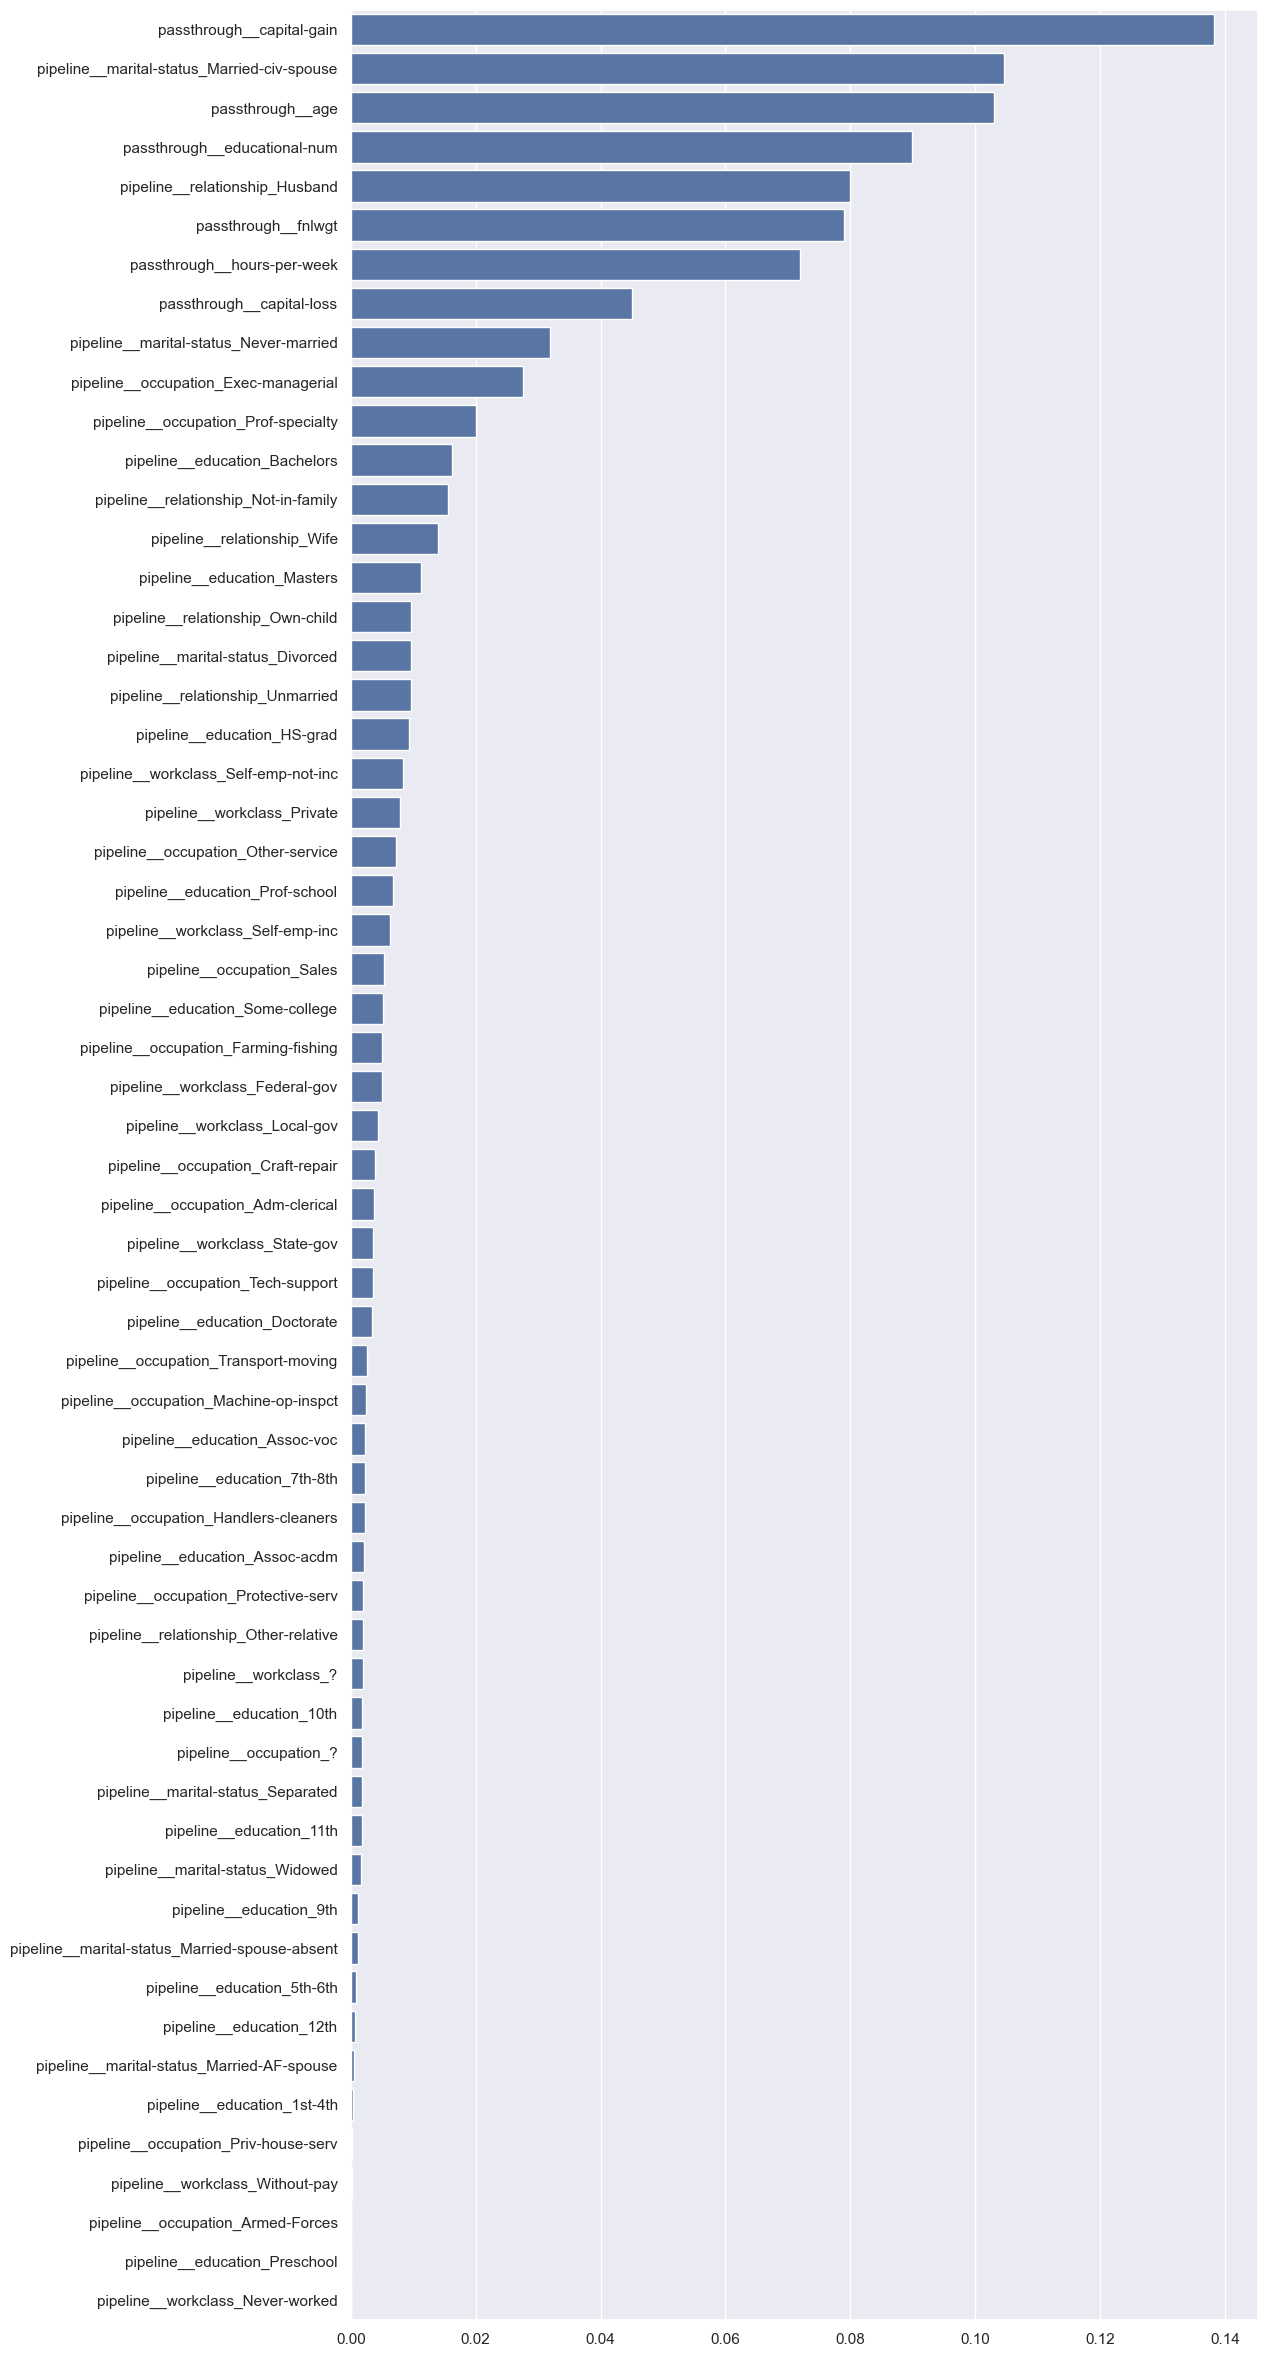

In [26]:
# Step 5 
feature_importances_new = clf_new.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices_new = feature_importances_new.argsort()[::-1]
sorted_feature_names_new = ct_new.get_feature_names_out()[sorted_indices_new]
sorted_importances_new = feature_importances_new[sorted_indices_new]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances_new, y=sorted_feature_names_new)

In [27]:
sorted_feature_names_new

array(['passthrough__capital-gain',
       'pipeline__marital-status_Married-civ-spouse', 'passthrough__age',
       'passthrough__educational-num', 'pipeline__relationship_Husband',
       'passthrough__fnlwgt', 'passthrough__hours-per-week',
       'passthrough__capital-loss',
       'pipeline__marital-status_Never-married',
       'pipeline__occupation_Exec-managerial',
       'pipeline__occupation_Prof-specialty',
       'pipeline__education_Bachelors',
       'pipeline__relationship_Not-in-family',
       'pipeline__relationship_Wife', 'pipeline__education_Masters',
       'pipeline__relationship_Own-child',
       'pipeline__marital-status_Divorced',
       'pipeline__relationship_Unmarried', 'pipeline__education_HS-grad',
       'pipeline__workclass_Self-emp-not-inc',
       'pipeline__workclass_Private',
       'pipeline__occupation_Other-service',
       'pipeline__education_Prof-school',
       'pipeline__workclass_Self-emp-inc', 'pipeline__occupation_Sales',
       'pipeline

<span style="color:blue"><b>Q4.5:</b> The top most important features for the classifier with scores greater than approximately 0.01 are `passthrough__capital-gain`, `pipeline__marital-status_Married-civ-spouse`, `passthrough__age`, `passthrough__educational-num`, `pipeline__relationship_Husband`, `passthrough__fnlwgt`, `passthrough__hours-per-week`, `passthrough__capital-loss`, `pipeline__marital-status_Never-married`, `pipeline__occupation_Exec-managerial`, `pipeline__occupation_Prof-specialty`, `pipeline__education_Bachelors`, `pipeline__relationship_Not-in-family`, `pipeline__relationship_Wife`, `pipeline__education_Masters`, `pipeline__relationship_Own-child`, `pipeline__marital-status_Divorced`, `pipeline__relationship_Unmarried` and `pipeline__education_HS-grad`. The only top most feature that was featured in the original model that did not appear in the above list was `pipeline__gender_Male`, which would have been excluded from the new model from the start.</span>

## Debiasing techniques: undersampling

As you should have seen when exploring the dataset, the groups of males and females who make more or less than \\$50k are of very different sizes. This alone may have a significant impact on the way the classifier is trained, by teaching it that some groups are much more likely to make more than \\$50k than others.

Let's try to fix this problem by creating a more balanced training set.

#### Question 5
1. Run the cell below to create a new training set by selecting a subset of samples from the original one, in which the groups of males and females who make more or less than \\$50k are of equal size. To use the maximum number of training samples possible, the size of each group should be equal to the size of the smallest of these groups in the original dataset. **What is the size of each group, and of the final training set?**
2. Separate features from target, and transform the cleaned dataset using one-hot encoding. **Remeber to re-transform the test set accordingly!**
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous ones. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Pay particular attention to the difference in results on the training and test set: can you explain these results?
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the previous ones?

In [28]:
# Check the distribution of gender and income
gender_distribution = train_df['gender'].value_counts()
income_distribution = train_df['income'].value_counts()

# Create balanced subsets
balanced_subsets = []
smallest = train_df.shape[0]

# Finding size of smallest subset by gender and income
for gender_category in gender_distribution.index:
    for income_category in income_distribution.index:
        if train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)].shape[0] < smallest:
            smallest = train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)].shape[0]
    
# Sampling subsets 
for gender_category in gender_distribution.index:
    for income_category in income_distribution.index:
        subset = train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)]
        subset = subset.sample(smallest, random_state=0)  # Sample to match the minimum count
        balanced_subsets.append(subset)
        
# Merge the balanced subsets to create the final balanced dataset
balanced_df = pd.concat(balanced_subsets)
print(balanced_df.shape, train_df[(train_df["gender"] == "Female") & (train_df["income"] == ">50K")].shape)

(4996, 15) (1249, 15)


<span style="color:blue"><b>Q5.1: </b>The size of the balanced training dataset is 4996, with $\frac{4996}{4}=1249$ samples in each combination group of `income` and `gender`, which matches the size of the smallest of these groups (Female with income >50K) in the original training dataset that only has 1249 samples.</span>

In [29]:
# STEP 1
# Run this cell create training and test sets
# train_df_bal, test_df_bal = train_test_split(balanced_df, test_size=0.3, random_state=123)

X_train_bal, y_train_bal = (
    balanced_df.drop(columns=["income"]),
    balanced_df["income"],
)
X_test_bal, y_test_bal = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

In [30]:
# Your answer here (you may add more cells) # Need to refit column transformer due to change in number of samples

# STEP 2
# Run this cell to do the necessary dataset preprocessing (encoding of categorical features).
# Note that, since we are using a tree based classifier, we don't need to scale the 
# numerical features.
categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct_bal = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed_bal = ct_bal.fit_transform(X_train_bal).toarray()
X_test_transformed_bal = ct_bal.transform(X_test_bal).toarray()

column_names_bal = list(
    ct_bal.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

In [31]:
# column_names_bal
X_test_transformed_bal

array([[ 0.,  0.,  0., ...,  0.,  0., 40.],
       [ 0.,  0.,  0., ...,  0.,  0., 30.],
       [ 0.,  1.,  0., ...,  0.,  0., 40.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., 40.],
       [ 0.,  0.,  0., ...,  0.,  0., 40.],
       [ 0.,  0.,  0., ...,  0.,  0., 40.]])

In [32]:
# STEP 3
# Run this cell to train a random forest classifer. The hyperparameters have been pre-selected

clf_bal = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_transformed_bal, y_train_bal)

In [33]:
# Step 4.1 
print("Training accuracy: " + str(clf.score(X_train_transformed, y_train)))
print("Testing accuracy: " + str(clf.score(X_test_transformed, y_test)))
print("Training accuracy (Balanced): " + str(clf_bal.score(X_train_transformed_bal, y_train_bal)))
print("Testing accuracy (Balanced): " + str(clf_bal.score(X_test_transformed_bal, y_test_bal)))

Training accuracy: 0.9064318932990143
Testing accuracy: 0.8624172524397734
Training accuracy (Balanced): 0.960568454763811
Testing accuracy (Balanced): 0.8035897085920972


In [34]:
# Step 4.2
# Splitting datasets by gender

X_train_transformed_bal = pd.DataFrame(X_train_transformed_bal, columns=column_names_bal)
X_test_transformed_bal = pd.DataFrame(X_test_transformed_bal, columns=column_names_bal)

X_train_transformed_bal_m_df = pd.DataFrame(X_train_transformed_bal[X_train_transformed_bal["gender_Male"] == 1], columns=column_names_bal)
X_train_transformed_bal_f_df = pd.DataFrame(X_train_transformed_bal[X_train_transformed_bal["gender_Male"] == 0], columns=column_names_bal)
X_test_transformed_bal_m_df = pd.DataFrame(X_test_transformed_bal[X_test_transformed_bal["gender_Male"] == 1], columns=column_names_bal)
X_test_transformed_bal_f_df = pd.DataFrame(X_test_transformed_bal[X_test_transformed_bal["gender_Male"] == 0], columns=column_names_bal)

y_train_bal_m = balanced_df[balanced_df["gender"] == "Male"]["income"]
y_train_bal_f = balanced_df[balanced_df["gender"] == "Female"]["income"]
y_test_bal_m = test_df[test_df["gender"] == "Male"]["income"]
y_test_bal_f = test_df[test_df["gender"] == "Female"]["income"]
# display(X_train_transformed_bal_m_df.head())

# fairness_metrics("Random Forest", clf_bal, X_train_transformed_bal_m_df, y_train_bal_m, X_train_transformed_bal_f_df, y_train_bal_f, "Training (Balanced)")
# fairness_metrics("Random Forest", clf_bal, X_test_transformed_bal_m_df, y_test_bal_m, X_test_transformed_bal_f_df, y_test_bal_f, "Testing (Balanced)")
fairness_metrics("Random Forest", clf_bal.predict(X_train_transformed_bal_m_df), y_train_bal_m, clf_bal.predict(X_train_transformed_bal_f_df), y_train_bal_f, "Training (Balanced)")
fairness_metrics("Random Forest", clf_bal.predict(X_test_transformed_bal_m_df), y_test_bal_m, clf_bal.predict(X_test_transformed_bal_f_df), y_test_bal_f, "Testing (Balanced)")
fairness_mets_df = pd.DataFrame(fairness_mets)
fairness_mets_df = fairness_mets_df.set_index(["model"])
fairness_mets_df

,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,adfr
model,,,,,,,
Random Forest (Training),0.175265,0.353936,0.389925,0.107931,0.255968,0.852545,0.644072
Random Forest (Testing),0.143736,0.288830,0.837058,0.188731,0.351694,1.211745,0.566949
Random Forest (Training (New)),0.176575,0.356581,0.337220,0.094040,0.253960,0.847751,0.655645
Random Forest (Testing (New)),0.150043,0.301504,0.987371,0.232391,0.352168,1.215761,0.532047
Random Forest (Training (Balanced)),0.949963,0.949963,0.378593,0.359649,0.709013,0.750000,0.317137
Random Forest (Testing (Balanced)),0.252283,0.506949,1.408318,0.557327,0.217873,0.843031,0.505143


<span style="color:blue"><b>Q5.4: </b>There are some significant changes in the accuracy and fairness metrics for each dataset after undersampling. The accuracy upon undersampling increased on the training set from 0.9064318932990143 to 0.960568454763811, and decreased slightly on the testing set from 0.8624172524397734 to 0.8035897085920972. There is a substantial increase in values for most the fairness metrics in the undersampled dataset compared to the original, with the exception of `FDRD`, `FNRD` and `adfr`. `PPRD` and `PPGRD` become very close in value to the reference value of 1, while `adfr` becomes relatively closer in value to the reference value of 0. `FDRD` is decreased for the training set and increased for the testing set, while `FNRD` is decreased for both the training and testing sets.</span>
#### <span style="color:purple"> Refined answer:</span>
<span style="color:purple"><b>Q5.4: </b>There are some significant changes in the accuracy and fairness metrics for each dataset after undersampling. The accuracy upon undersampling increased on the training set from 0.9064318932990143 to 0.960568454763811, and decreased slightly on the testing set from 0.8624172524397734 to 0.8035897085920972. The increase in training accuracy and decrease in testing accuracy indicates the model is slightly overfitted to the data. There is a substantial increase in values for most the fairness metrics in the undersampled dataset compared to the original, with the exception of `FDRD`, `FNRD` and `adfr`. `PPRD` and `PPGRD` become very close in value to the reference value of 1, while `adfr` becomes relatively closer in value to the reference value of 0. `FDRD` is decreased for the training set and increased for the testing set, while `FNRD` is decreased for both the training and testing sets.</span>

<Axes: >

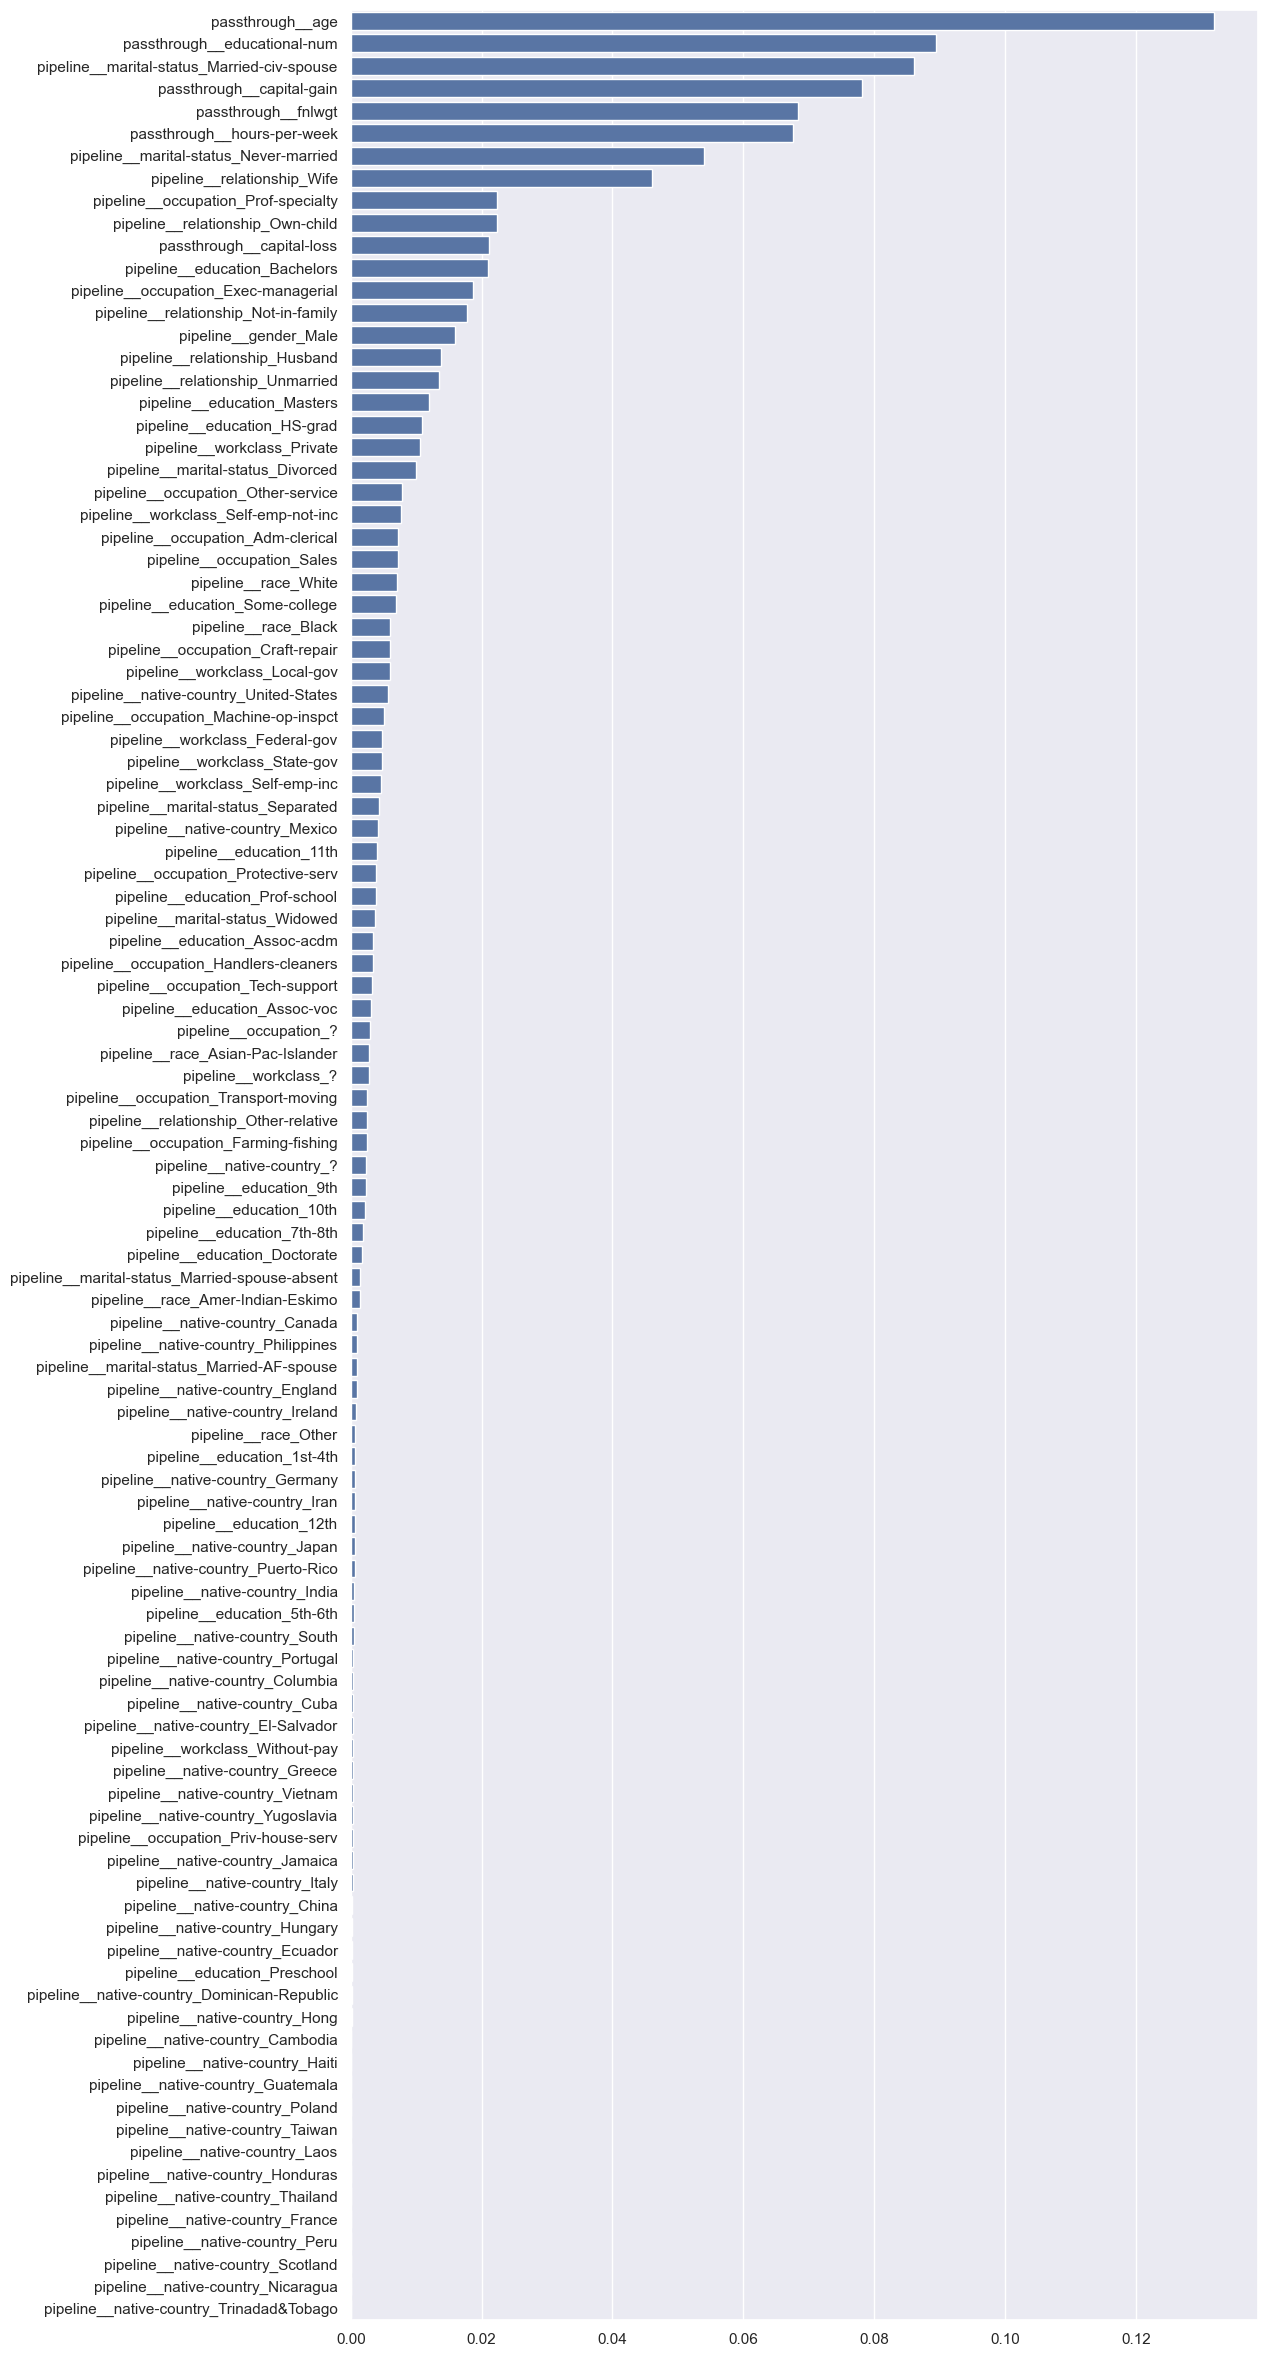

In [35]:
# Step 5 
feature_importances_bal = clf_bal.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices_bal = feature_importances_bal.argsort()[::-1]
sorted_feature_names_bal = ct_bal.get_feature_names_out()[sorted_indices_bal]
sorted_importances_bal = feature_importances_bal[sorted_indices_bal]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances_bal, y=sorted_feature_names_bal)

In [36]:
sorted_feature_names_bal

array(['passthrough__age', 'passthrough__educational-num',
       'pipeline__marital-status_Married-civ-spouse',
       'passthrough__capital-gain', 'passthrough__fnlwgt',
       'passthrough__hours-per-week',
       'pipeline__marital-status_Never-married',
       'pipeline__relationship_Wife',
       'pipeline__occupation_Prof-specialty',
       'pipeline__relationship_Own-child', 'passthrough__capital-loss',
       'pipeline__education_Bachelors',
       'pipeline__occupation_Exec-managerial',
       'pipeline__relationship_Not-in-family', 'pipeline__gender_Male',
       'pipeline__relationship_Husband',
       'pipeline__relationship_Unmarried', 'pipeline__education_Masters',
       'pipeline__education_HS-grad', 'pipeline__workclass_Private',
       'pipeline__marital-status_Divorced',
       'pipeline__occupation_Other-service',
       'pipeline__workclass_Self-emp-not-inc',
       'pipeline__occupation_Adm-clerical', 'pipeline__occupation_Sales',
       'pipeline__race_White', '

<span style="color:blue"><b>Q5.5:</b>The top most important features for the classifier with scores greater than approximately 0.01 are `passthrough__age`, `pipeline__marital-status_Married-civ-spouse`, `passthrough__educational-num`, `passthrough__capital-gain`, `passthrough__fnlwgt`, `passthrough__hours-per-week`, `pipeline__relationship_Wife`, `pipeline__marital-status_Never-married`, `pipeline__occupation_Exec-managerial`, `pipeline__relationship_Husband`, `passthrough__capital-loss`, `pipeline__relationship_Own-child`, `pipeline__occupation_Prof-specialty`, `pipeline__education_Bachelors`, `pipeline__gender_Male`, `pipeline__relationship_Not-in-family`, `pipeline__education_Masters`, `pipeline__workclass_Private`, `pipeline__marital-status_Divorced`, `pipeline__occupation_Other-service`, `pipeline__relationship_Unmarried`, and `pipeline__education_HS-grad`. Compared to the original model, the features `pipeline__workclass_Private`, `pipeline__occupation_Other-service`, `pipeline__relationship_Unmarried` and `pipeline__education_HS-grad` have significantly greater importance relative to the other model features.</span>

## Debiasing techniques: oversampling (with SMOTE)

Another way to create a more balanced training set, but without sacrificing training samples, is by *oversampling*, which means artificially increasing the size of the training set with "fake" samples. This can be achieved mainly in two ways:
1. By resampling (replicating) samples from the original training set, or
2. By introducing artificial *new* samples, similar enough to those included in the original training set

The Synthetic Minority Oversampling Technique (SMOTE) seen in class falls in the second group. In this portion of the assignment, you will create a more balanced dataset using SMOTE (specifically [SMOTENC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html), a version of SMOTE that allows working with categorical variables).

#### Question 6
1. Run the cell below to create a more balanced training set using SMOTE. Note that a large portion of code is replicated to guarantee that the correct data is used, and not one modified in previous cells. The actual rebalancing all happens in the last 2 lines.
2. Explore the new training set, and provide the following information: what is the size of the new training set? Is the target variable balanced? How many samples are classified as >\\$50, and how many as <=\\$50k? Is the target variable balanced across protected groups, or at least more balanced than before? How many males and females are classified as >\\$50, and how many as <=\\$50k?
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous ones. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Pay particular attention to the difference in results on the training and test set: can you explain these results?
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the previous ones?

In [37]:
from imblearn.over_sampling import SMOTENC

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

oversample = SMOTENC(categorical_features=categorical_feats, random_state=0)

X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

In [38]:
# Transformation applied after oversampling

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"


ctSMOTE = make_column_transformer(
    (
        OneHotEncoder(handle_unknown="ignore",drop="if_binary",sparse_output=False),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

# X_train_transformed = ctSMOTE.fit_transform(X_train_SMOTE)
# X_test_transformed = ctSMOTE.transform(X_test)
X_train_transformed_SMOTE = ctSMOTE.fit_transform(X_train_SMOTE)
X_test_transformed_SMOTE = ctSMOTE.transform(X_test)

# Column names, if needed
column_names_SMOTE = list(
    ctSMOTE.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

# X_train_transformed and X_test_transformed can now be used to answer the questions above

In [39]:
# Your answer here (you may add more cells)
train_df_SMOTE = pd.concat([X_train_SMOTE, y_train_SMOTE], axis=1)

# print(train_df_SMOTE.size) # 779520
print(train_df_SMOTE.shape) # (51968, 15)
display(y_train_SMOTE.value_counts(normalize=True).sort_index()) # Balance?
display(y_train_SMOTE.value_counts(normalize=False).sort_index()) # Number of each 
# display(train_df_SMOTE.head())

(51968, 15)


income
<=50K    0.5
>50K     0.5
Name: proportion, dtype: float64

income
<=50K    25984
>50K     25984
Name: count, dtype: int64

<span style="color:blue"><b>Q6.2.1, 6.2.2, 6.2.3:</b>The size of the new training set is 51968 samples. Overall, the target variable is balanced, with 25984 samples classified as `income == "<=50K"` and 25984 samples classified as `income == ">50K"`.</span>

In [40]:
genders = df["gender"].astype("string").value_counts().sort_index().index
genders_2 = train_df_SMOTE["gender"].astype("string").value_counts().sort_index().index
# print(genders)
# print(genders_2)

for gen in genders_2: 
    data = df[df["gender"] == gen]
    print("Distribution of income for " + gen.lower() + " overall")
    display(data["income"].value_counts(normalize=True).sort_index())
    
    data_2 = train_df_SMOTE[train_df_SMOTE["gender"] == gen]
    print("Distribution of income for " + gen.lower() + " in SMOTE training set")
    display(data_2["income"].value_counts(normalize=True).sort_index())

for gen in genders_2: 
    data_2 = train_df_SMOTE[train_df_SMOTE["gender"] == gen]
    print("Count of income for " + gen.lower() + " in SMOTE training set")
    display(data_2["income"].value_counts(normalize=False).sort_index())

Distribution of income for female overall


income
<=50K    0.890749
>50K     0.109251
Name: proportion, dtype: float64

Distribution of income for female in SMOTE training set


income
<=50K    0.836503
>50K     0.163497
Name: proportion, dtype: float64

Distribution of income for male overall


income
<=50K    0.696233
>50K     0.303767
Name: proportion, dtype: float64

Distribution of income for male in SMOTE training set


income
<=50K    0.398497
>50K     0.601503
Name: proportion, dtype: float64

Count of income for female in SMOTE training set


income
<=50K    10074
>50K      1969
Name: count, dtype: int64

Count of income for male in SMOTE training set


income
<=50K    15910
>50K     24015
Name: count, dtype: int64

<span style="color:blue"><b>Q6.2.4.1, 6.2.5:</b>The target variable `income` is only slightly more balanced across each `gender` group compared to the original dataset, and the distributions of each `income` category are not equal across each level of `gender`. For instance, the proportion of `income == "<=50K"` samples is 0.836503 among female individuals and 0.398497 among male individuals. There are 15910 males and 10074 females classified as `income == "<=50K"`, and 24015 males and 1969 females classified as `income == "<=50K"`.</span>

In [41]:
races = df["race"].astype("string").value_counts().sort_index().index
races_2 = train_df_SMOTE["race"].astype("string").value_counts().sort_index().index
# print(races)
# print(races_2)

for gen in races_2: 
    data = df[df["race"] == gen]
    print("Distribution of income for " + gen.lower() + " overall")
    display(data["income"].value_counts(normalize=True).sort_index())

    data_2 = train_df_SMOTE[train_df_SMOTE["race"] == gen]
    print("Distribution of income for " + gen.lower() + " in SMOTE training set")
    display(data_2["income"].value_counts(normalize=True).sort_index())

Distribution of income for amer-indian-eskimo overall


income
<=50K    0.882979
>50K     0.117021
Name: proportion, dtype: float64

Distribution of income for amer-indian-eskimo in SMOTE training set


income
<=50K    0.904908
>50K     0.095092
Name: proportion, dtype: float64

Distribution of income for asian-pac-islander overall


income
<=50K    0.730744
>50K     0.269256
Name: proportion, dtype: float64

Distribution of income for asian-pac-islander in SMOTE training set


income
<=50K    0.684073
>50K     0.315927
Name: proportion, dtype: float64

Distribution of income for black overall


income
<=50K    0.879189
>50K     0.120811
Name: proportion, dtype: float64

Distribution of income for black in SMOTE training set


income
<=50K    0.857315
>50K     0.142685
Name: proportion, dtype: float64

Distribution of income for other overall


income
<=50K    0.876847
>50K     0.123153
Name: proportion, dtype: float64

Distribution of income for other in SMOTE training set


income
<=50K    0.879195
>50K     0.120805
Name: proportion, dtype: float64

Distribution of income for white overall


income
<=50K    0.746013
>50K     0.253987
Name: proportion, dtype: float64

Distribution of income for white in SMOTE training set


income
<=50K    0.464996
>50K     0.535004
Name: proportion, dtype: float64

<span style="color:blue"><b>Q6.2.4.2:</b>The target variable `income` is only slightly more balanced across each `race` group 
Compared to the original dataset, the target variable `income` is significantly more balanced for `race == "white"`, only slightly more balanced for `race == "asian-pac-islander"` and `race == "black"`, and slightly less balanced for `race == "amer-indian-eskimo"` and `race == "other"`. The distributions of each `income` category are not equal across each level of `race`. For instance, the proportion of `income == "<=50K"` samples is 0.904908 among amer-indian-eskimo individuals and 0.464996 among white individuals.</span>

In [42]:
# Step 3
clf_SMOTE = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_transformed_SMOTE, y_train_SMOTE)

In [43]:
# Step 4.1 
print("Training accuracy: " + str(clf.score(X_train_transformed, y_train)))
print("Testing accuracy: " + str(clf.score(X_test_transformed, y_test)))
print("Training accuracy (SMOTE): " + str(clf_SMOTE.score(X_train_transformed_SMOTE, y_train_SMOTE)))
print("Testing accuracy (SMOTE): " + str(clf_SMOTE.score(X_test_transformed_SMOTE, y_test)))

Training accuracy: 0.9064318932990143
Testing accuracy: 0.8624172524397734
Training accuracy (SMOTE): 0.9203163485221675
Testing accuracy (SMOTE): 0.8413294205964649


In [44]:
# Step 4.2
# Splitting datasets by gender

X_train_transformed_SMOTE = pd.DataFrame(X_train_transformed_SMOTE, columns=column_names_SMOTE)
X_test_transformed_SMOTE = pd.DataFrame(X_test_transformed_SMOTE, columns=column_names_SMOTE)

X_train_transformed_SMOTE_m_df = pd.DataFrame(X_train_transformed_SMOTE[X_train_transformed_SMOTE["gender_Male"] == 1], columns=column_names_SMOTE)
X_train_transformed_SMOTE_f_df = pd.DataFrame(X_train_transformed_SMOTE[X_train_transformed_SMOTE["gender_Male"] == 0], columns=column_names_SMOTE)
X_test_transformed_SMOTE_m_df = pd.DataFrame(X_test_transformed_SMOTE[X_test_transformed_SMOTE["gender_Male"] == 1], columns=column_names_SMOTE)
X_test_transformed_SMOTE_f_df = pd.DataFrame(X_test_transformed_SMOTE[X_test_transformed_SMOTE["gender_Male"] == 0], columns=column_names_SMOTE)

y_train_SMOTE_m = train_df_SMOTE[train_df_SMOTE["gender"] == "Male"]["income"]
y_train_SMOTE_f = train_df_SMOTE[train_df_SMOTE["gender"] == "Female"]["income"]
y_test_SMOTE_m = test_df[test_df["gender"] == "Male"]["income"]
y_test_SMOTE_f = test_df[test_df["gender"] == "Female"]["income"]
# display(X_train_transformed_bal_m_df.head())

# fairness_metrics("Random Forest", clf_SMOTE, X_train_transformed_SMOTE_m_df, y_train_SMOTE_m, X_train_transformed_SMOTE_f_df, y_train_SMOTE_f, "Training (SMOTE)")
# fairness_metrics("Random Forest", clf_SMOTE, X_test_transformed_SMOTE_m_df, y_test_SMOTE_m, X_test_transformed_SMOTE_f_df, y_test_SMOTE_f, "Testing (SMOTE)")
fairness_metrics("Random Forest", clf_SMOTE.predict(X_train_transformed_SMOTE_m_df), y_train_SMOTE_m, clf_SMOTE.predict(X_train_transformed_SMOTE_f_df), y_train_SMOTE_f, "Training (SMOTE)")
fairness_metrics("Random Forest", clf_SMOTE.predict(X_test_transformed_SMOTE_m_df), y_test_SMOTE_m, clf_SMOTE.predict(X_test_transformed_SMOTE_f_df), y_test_SMOTE_f, "Testing (SMOTE)")
fairness_mets_df = pd.DataFrame(fairness_mets)
fairness_mets_df = fairness_mets_df.set_index(["model"])
fairness_mets_df

,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,adfr
model,,,,,,,
Random Forest (Training),0.175265,0.353936,0.389925,0.107931,0.255968,0.852545,0.644072
Random Forest (Testing),0.143736,0.288830,0.837058,0.188731,0.351694,1.211745,0.566949
Random Forest (Training (New)),0.176575,0.356581,0.337220,0.094040,0.253960,0.847751,0.655645
Random Forest (Testing (New)),0.150043,0.301504,0.987371,0.232391,0.352168,1.215761,0.532047
Random Forest (Training (Balanced)),0.949963,0.949963,0.378593,0.359649,0.709013,0.750000,0.317137
Random Forest (Testing (Balanced)),0.252283,0.506949,1.408318,0.557327,0.217873,0.843031,0.505143
Random Forest (Training (SMOTE)),0.072344,0.239834,0.779045,0.089008,0.357397,3.117290,0.929944
Random Forest (Testing (SMOTE)),0.105559,0.212114,0.681541,0.112852,0.498124,2.101040,0.748475


<span style="color:blue"><b>Q6.4:</b> There are some significant changes in the accuracy and fairness metrics for each dataset after using SMOTE. The accuracy upon undersampling increased slightly on the training set from 0.9064318932990143 to 0.9203163485221675, and decreased slightly on the testing set from 0.8624172524397734 to 0.8413294205964649. `PPRD`, `PPGRD` and `FPRD` are decreased significantly for the training and testing sets, `FORD`, `FNRD`, and `adfr` are increased significantly for both the training and testing sets, and `FDRD` is increased for the training sets and decreased for the testing sets. `FNRD` becoming relatively further in value from the reference value of 1. As a consequence, `adfr` is increased significantly for both the training and testing sets.</span>
#### <span style="color:purple"> Refined answer:</span>
<span style="color:purple"><b>Q6.4:</b> There are some significant changes in the accuracy and fairness metrics for each dataset after using SMOTE. The accuracy upon undersampling increased slightly on the training set from 0.9064318932990143 to 0.9203163485221675, and decreased slightly on the testing set from 0.8624172524397734 to 0.8413294205964649, indicating slight overfitting for the model to the training set. `PPRD`, `PPGRD` and `FPRD` are decreased significantly for the training and testing sets, `FORD`, `FNRD`, and `adfr` are increased significantly for both the training and testing sets, and `FDRD` is increased for the training sets and decreased for the testing sets. `FNRD` becoming relatively further in value from the reference value of 1. As a consequence, `adfr` is increased significantly for both the training and testing sets. The results of the model on the testing set indicate more fair metrics overall compared to the results on the training set.</span>

<Axes: >

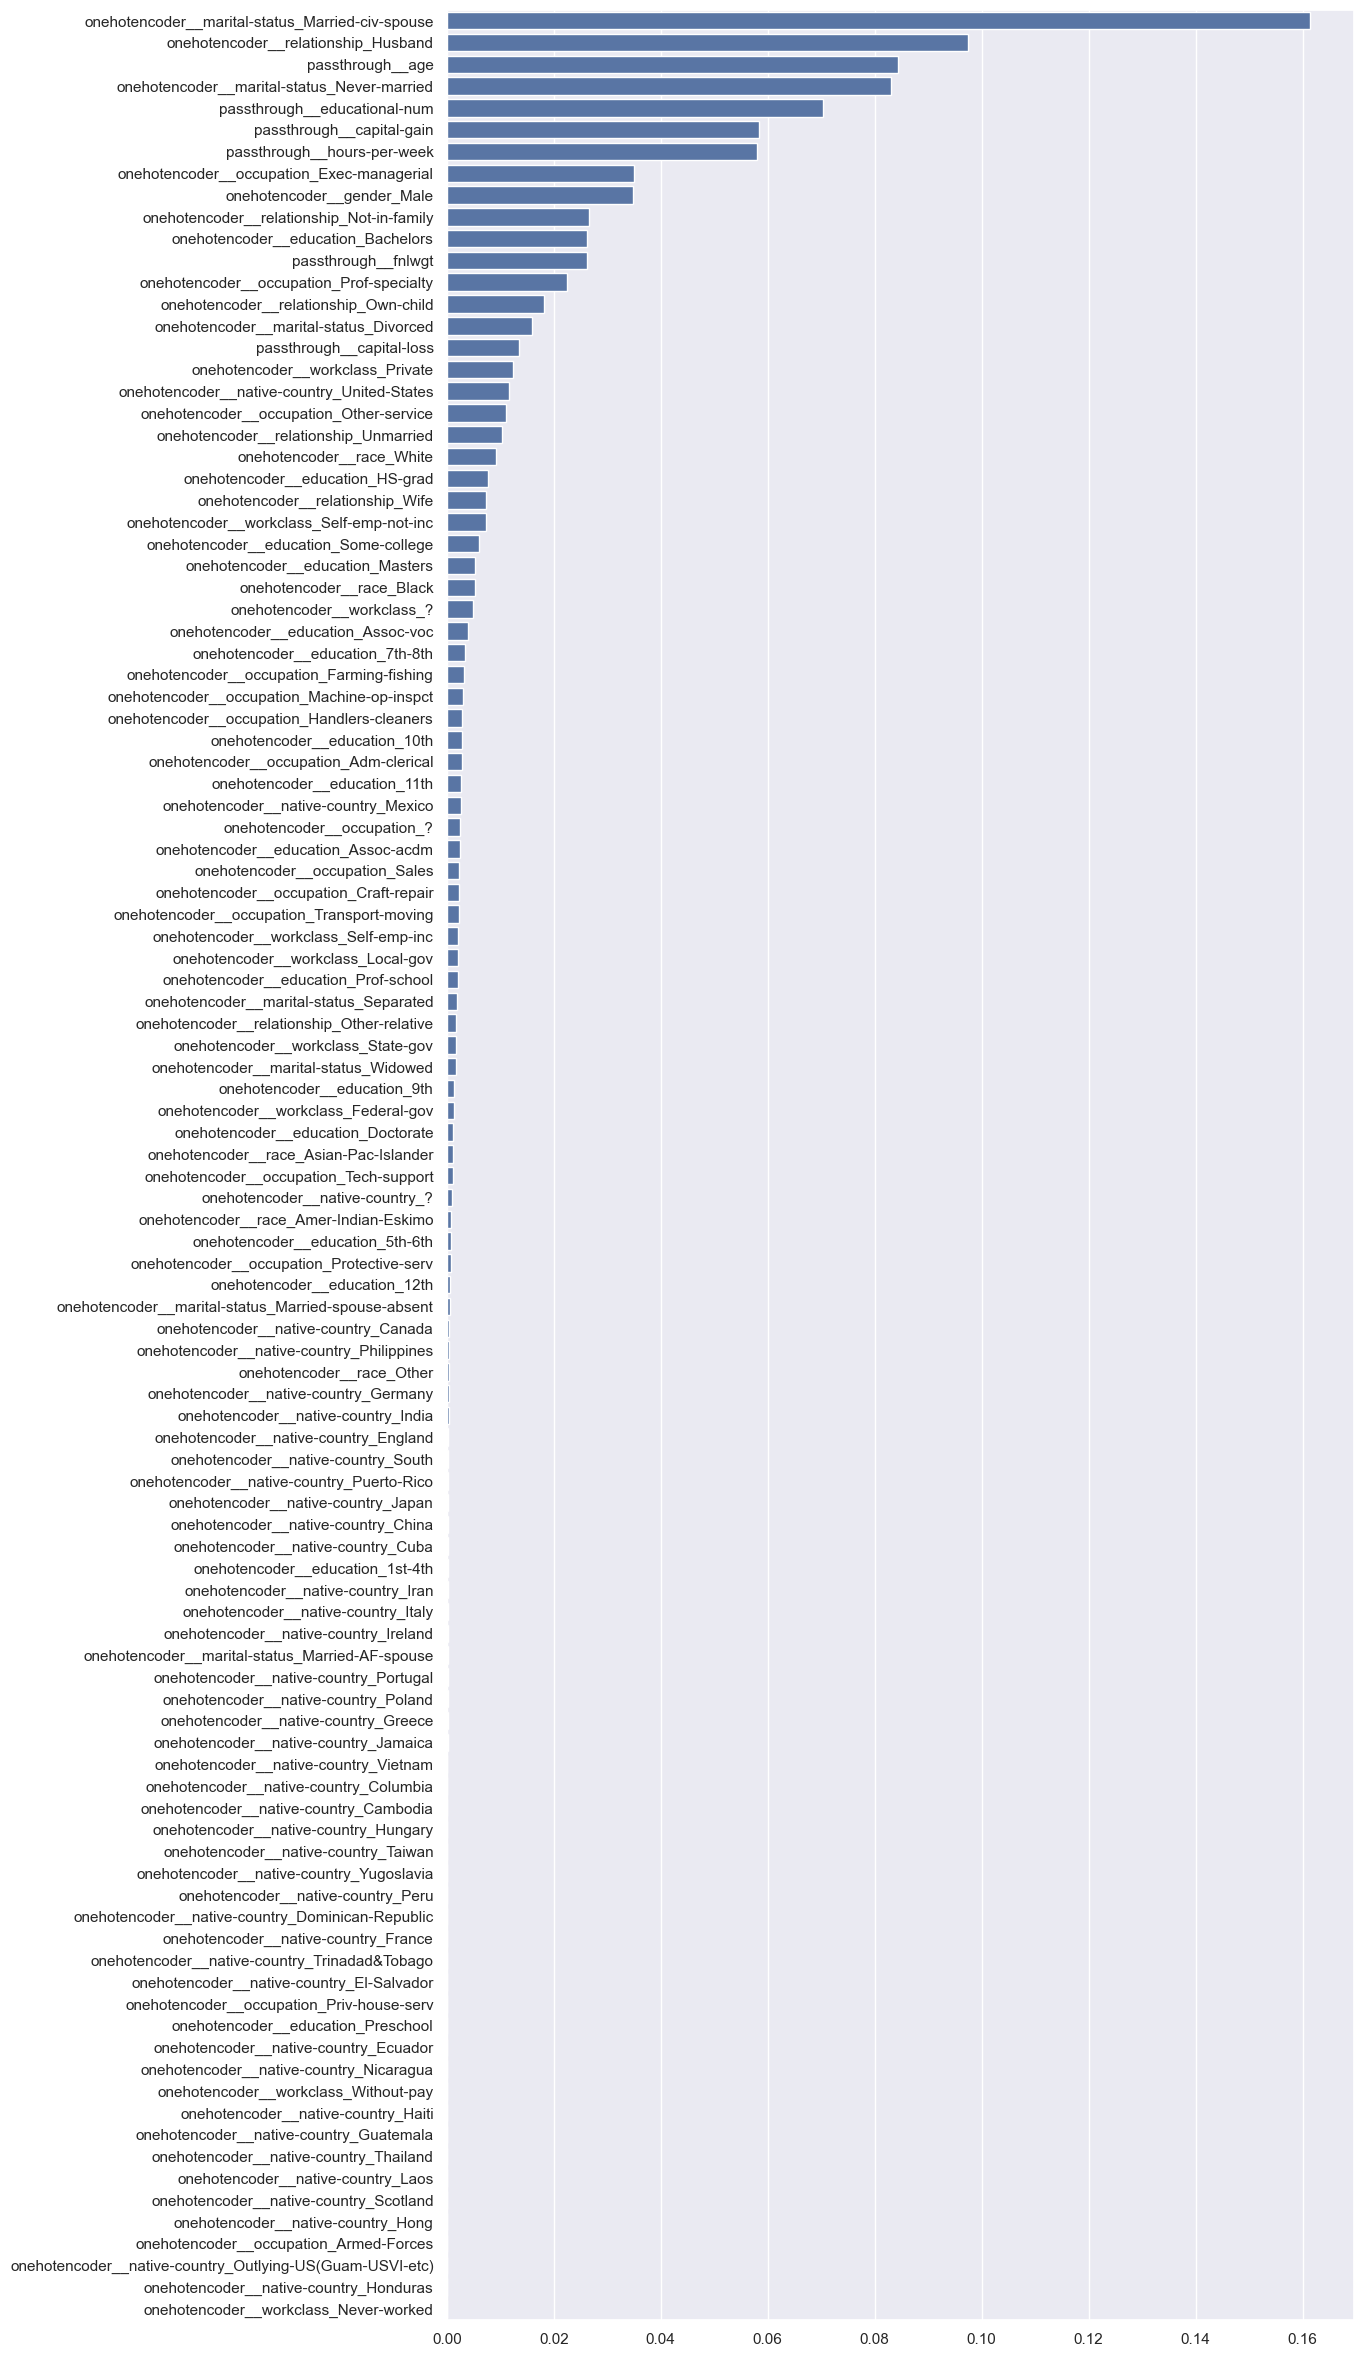

In [45]:
# Step 5 
feature_importances_SMOTE = clf_SMOTE.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices_SMOTE = feature_importances_SMOTE.argsort()[::-1]
sorted_feature_names_SMOTE = ctSMOTE.get_feature_names_out()[sorted_indices_SMOTE]
sorted_importances_SMOTE = feature_importances_SMOTE[sorted_indices_SMOTE]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances_SMOTE, y=sorted_feature_names_SMOTE)

In [46]:
sorted_feature_names_SMOTE

array(['onehotencoder__marital-status_Married-civ-spouse',
       'onehotencoder__relationship_Husband', 'passthrough__age',
       'onehotencoder__marital-status_Never-married',
       'passthrough__educational-num', 'passthrough__capital-gain',
       'passthrough__hours-per-week',
       'onehotencoder__occupation_Exec-managerial',
       'onehotencoder__gender_Male',
       'onehotencoder__relationship_Not-in-family',
       'onehotencoder__education_Bachelors', 'passthrough__fnlwgt',
       'onehotencoder__occupation_Prof-specialty',
       'onehotencoder__relationship_Own-child',
       'onehotencoder__marital-status_Divorced',
       'passthrough__capital-loss', 'onehotencoder__workclass_Private',
       'onehotencoder__native-country_United-States',
       'onehotencoder__occupation_Other-service',
       'onehotencoder__relationship_Unmarried',
       'onehotencoder__race_White', 'onehotencoder__education_HS-grad',
       'onehotencoder__relationship_Wife',
       'onehotencod

<span style="color:blue"><b>Q6.5:</b> The top most important features for the classifier with scores greater than approximately 0.01 are `onehotencoder__marital-status_Married-civ-spouse`, `onehotencoder__relationship_Husband`, `passthrough__age`, `onehotencoder__marital-status_Never-married`, `passthrough__educational-num`, `passthrough__capital-gain`, `passthrough__hours-per-week`, `onehotencoder__occupation_Exec-managerial`, `onehotencoder__gender_Male`, `onehotencoder__relationship_Not-in-family`, `onehotencoder__education_Bachelors`, `passthrough__fnlwgt`, `onehotencoder__occupation_Prof-specialty`, `onehotencoder__relationship_Own-child`, `onehotencoder__marital-status_Divorced`, `passthrough__capital-loss`, `onehotencoder__workclass_Private`, `onehotencoder__native-country_United-States`, `onehotencoder__occupation_Other-service`, `onehotencoder__relationship_Unmarried`, and `onehotencoder__race_White`. Compared to the previous models, the features `onehotencoder__native-country_United-States`and `onehotencoder__race_White` have significantly greater importance relative to the other model features. `pipeline__education_Masters` has significantly less importance compared to the original model, while `pipeline__education_HS-grad` has significantly less importance compared to the undersampling model.
</span>

## Equalized odd post processing

An alternative to the methods seen so far (which may produce unsatisfactory results), is applying post-processing to the predictions of the classifier, so that they optimize equalized odds (whether the TPR and FPR are on par across groups).

`aif360`, a popular open-source library dedicated to detecting and mitigating bias in machine learning models, includes [`EqOddsPostprocessing`](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.postprocessing.EqOddsPostprocessing.html), a function to performe equalized odds post-processing. The function is slightly more intricate to use than others you have used so far (typically from `sklearn`), so we will see together how to apply it on the test (you may try and replicate this on the training set for your own practice).

In [47]:
# Run this cell to reset training and test sets (and clear accidental prior changes)

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

In [48]:
# Run this cell to do the necessary dataset preprocessing (encoding of categorical features).
# Note that, since we are using a tree based classifier, we don't need to scale the 
# numerical features.

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ct.fit_transform(X_train).toarray()
X_test_transformed = ct.transform(X_test).toarray()

In [49]:
# Convert numpy arrays to pandas dataframes

column_names = list(
    ct.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

X_train_df = pd.DataFrame(X_train_transformed, columns=column_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=column_names)

In [50]:
# Train RandomForestClassifier
clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_df, y_train)

# Get predictions for test set 
y_pred = clf.predict(X_test_df)

# So far, all this is the same as the biased classifier we started with 

In [51]:
# Convert test data into a BinaryLabelDataset, necessary to work in aif360

from aif360.datasets import BinaryLabelDataset

X_test_df = X_test_df.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_binary = y_test.map({'>50K': 1, '<=50K': 0})  # Map categorical values to binary

test_mld = BinaryLabelDataset(df=pd.concat([X_test_df, y_binary], axis=1),
                              label_names=['income'],
                              protected_attribute_names=['gender_Male'])

In [52]:
# Create another dataset with predicted labels for comparison
test_pred_mld = test_mld.copy()

# Convert to binary label (e.g., class 2 is positive, others are negative)
y_pred_binary = np.where(y_pred == '>50K', 1, 0)

test_pred_mld.labels = y_pred_binary.reshape(-1, 1)

In [53]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

# Initialize EqOddsPostprocessing
eq_odds = EqOddsPostprocessing(unprivileged_groups=[{'gender_Male': 0}],
                               privileged_groups=[{'gender_Male': 1}], seed=0)

In [54]:
# Fit the EqOddsPostprocessing model # Changing of predictions 
eq_odds = eq_odds.fit(test_mld, test_pred_mld)

# Get new fair predictions
fair_pred_mld = eq_odds.predict(test_pred_mld)

# Convert predictions back to array
fair_predictions = fair_pred_mld.labels

In [55]:
# Modified predictions
fair_predictions_cat = np.where(fair_predictions == 1, '>50K', '<=50K')
fair_predictions_cat 

array([['<=50K'],
       ['<=50K'],
       ['<=50K'],
       ...,
       ['<=50K'],
       ['<=50K'],
       ['<=50K']], dtype='<U5')

`fair_predictions_cat` now includes the post-processed predictions, after equalized odds postprocessing. 

#### Question 7

Compute accuracy and fairness of this new predictions, and compare the results to the previous ones. Do we see any improvement? Is this technique more or less effective than the others tried before?

In [56]:
print("Training accuracy: " + str(clf.score(X_train_transformed, y_train)))
print("Testing accuracy: " + str(clf.score(X_test_transformed, y_test)))
# print("Training accuracy (EqOddsPostprocessing): " + str(clf.score(X_train_df, fair_predictions_cat))) # NOT SURE WHAT TO DO WITH THIS
print("Testing accuracy (EqOddsPostprocessing): " + str(clf.score(X_test_df, fair_predictions_cat)))

Training accuracy: 0.9064318932990143
Testing accuracy: 0.8624172524397734
Testing accuracy (EqOddsPostprocessing): 0.9680611478878045


In [57]:
y_test_eq_odds = pd.DataFrame(fair_predictions_cat, columns = ["income"])
test_df_eq_odds = pd.concat([X_test_df, y_test_eq_odds], axis=1)
# test_df_eq_odds["gender_Male"]
# display(test_df_eq_odds)

X_test_eq_odds_m = pd.DataFrame(X_test_df[X_test_df["gender_Male"] == 1])
X_test_eq_odds_f = pd.DataFrame(X_test_df[X_test_df["gender_Male"] == 0])
# display(X_test_eq_odds_m.head())

y_test_eq_odds_m = test_df_eq_odds[test_df_eq_odds["gender_Male"] == 1]["income"]
y_test_eq_odds_f = test_df_eq_odds[test_df_eq_odds["gender_Male"] == 0]["income"]
# display(y_test_eq_odds_m.head())

y_test_m = test_df[test_df["gender"] == "Male"]["income"]
y_test_f = test_df[test_df["gender"] == "Female"]["income"]
# display(y_test_eq_odds_m.head())

# cm_m_eq_odds = confusion_matrix(y_test_eq_odds_m, clf.predict(X_test_eq_odds_m)) # y_test_eq_odds_m as true value, but not 
# cm_f_eq_odds = confusion_matrix(y_test_eq_odds_f, clf.predict(X_test_eq_odds_f))
cm_m_eq_odds = confusion_matrix(y_test_m, y_test_eq_odds_m) # clf is not model
cm_f_eq_odds = confusion_matrix(y_test_f, y_test_eq_odds_f)
print(cm_m_eq_odds)
print(cm_f_eq_odds)

# fairness_metrics("Random Forest", clf, X_test_eq_odds_m, y_test_eq_odds_m, X_test_eq_odds_f, y_test_eq_odds_f, "Testing (EqOddsPostprocessing)")
fairness_metrics("Random Forest", y_test_eq_odds_m, y_test_m, y_test_eq_odds_f, y_test_f, "Testing (EqOddsPostprocessing)")
fairness_mets_df = pd.DataFrame(fairness_mets)
fairness_mets_df = fairness_mets_df.set_index(["model"])
fairness_mets_df

[[6353  469]
 [1381 1581]]
[[4060  289]
 [ 239  281]]


,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,adfr
model,,,,,,,
Random Forest (Training),0.175265,0.353936,0.389925,0.107931,0.255968,0.852545,0.644072
Random Forest (Testing),0.143736,0.288830,0.837058,0.188731,0.351694,1.211745,0.566949
Random Forest (Training (New)),0.176575,0.356581,0.337220,0.094040,0.253960,0.847751,0.655645
Random Forest (Testing (New)),0.150043,0.301504,0.987371,0.232391,0.352168,1.215761,0.532047
Random Forest (Training (Balanced)),0.949963,0.949963,0.378593,0.359649,0.709013,0.750000,0.317137
Random Forest (Testing (Balanced)),0.252283,0.506949,1.408318,0.557327,0.217873,0.843031,0.505143
Random Forest (Training (SMOTE)),0.072344,0.239834,0.779045,0.089008,0.357397,3.117290,0.929944
Random Forest (Testing (SMOTE)),0.105559,0.212114,0.681541,0.112852,0.498124,2.101040,0.748475
Random Forest (Testing (EqOddsPostprocessing)),0.278049,0.558724,2.216175,0.966601,0.311344,0.985793,0.519277


<span style="color:blue">There are some significant changes in the accuracy and fairness metrics for each dataset after using equalised odd post processing. The accuracy upon equalised odds post processing on the testing set is increased from 0.8624172524397734 to 0.9680611478878045. `PPRD`, `PPGRD`, `FDRD` and `FPRD` are increased for the testing set after equalising odds post processing, while `FORD`, `FNRD` and `adfr` are decreased. `PPRD`, `PPGRD`, `FPRD` and `FNRD` are closer in value to the reference value of 1, while `FDRD` and `FORD` are further in value from the reference value. Overall, `adfr` is decreased.</span>

## Final remarks

#### Question 8

Based on the results seen so far, provide an overall evaluation of our debiasing efforts. In particular, try answering the following questions:
1. What do you think was the most successful technique? Which one was the least successful? 
2. If you found that bias still persists after attempting a debiasing strategy, what do you think is the reason? What could be done to fix this problem?

(max 400 words)

<span style="color:blue">**Q8.1**: The technique that was most successful in debiasing this dataset was the undersampling technique, as it provided the smallest absolute value of `adfr` for training and testing sets, which acts as a measure of overall fairness of the classifications. However, equalised odds provides better testing `PPRD`, `PPGRD`, `FPRD` and `FNRD` scores closer to 1, the removal of protected characteristics provides a better testing `FDRD` score closer to 1, and SMOTE oversampling provides a better testing `FORD` score closer to 1. Oversampling with SMOTE was the least successful in debiasing the dataset, as it has managed to cause every fairness metric except `FDRD` and `FORD` to deviate further from the reference value of 1, leading to an overall increase in `adfr` for both datasets.</span>

<span style="color:blue">**Q8.2**: Bias after the debiasing strategy may be due to the features selected for greater importance on the debiased dataset (e.g. Protected characteristics) or due to the model of choice in measuring bias. The issue may be mitigated by further debiasing through iterative debiasing techniques or by selecting models with less inherent bias.</span>

#### <span style="color:purple"> Refined answer:</span>
<span style="color:purple">**Q8.1**: The techniques that was most successful in debiasing this dataset was the equalised odds technique, as it provided a small absolute value of `adfr` for the testing set, which acts as a measure of overall fairness of the classifications, along with providing better testing `PPRD`, `PPGRD`, `FPRD` and `FNRD` scores closer to 1. However, it does provide relatively poor `FDRD` and `FORD` testing set scores of 2.216175 and 0.311344 that are further from 1 than at least one of the remaining models, leading to a less extreme decrease in `adfr` than expected. Specifically, the removal of protected characteristics provides a better testing `FDRD` score closer to 1, and SMOTE oversampling provides a better testing `FORD` score closer to 1. Oversampling with SMOTE was the least successful in debiasing the dataset, as it has managed to cause every fairness metric except `FDRD` and `FORD` to deviate further from the reference value of 1, leading to an overall increase in `adfr` for both datasets. It should be noted that given their relatively high `adfr` scores on the testing set, none of the given techniques were particularly successful on unseen samples.</span>

<span style="color:purple">**Q8.2**: Bias after the debiasing strategy may be due to the features selected for greater importance on the debiased dataset (e.g. Protected characteristics) or due to the model of choice in measuring bias. The issue may be mitigated by further debiasing through iterative debiasing techniques or by selecting models with less inherent bias.</span>

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

<span style="color:blue">We worked on the assignment separately, each taking turns to answer all parts and modifying the responses down the line.</span>

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

* <span style="color:blue">Jingyuan's response: I used ChatGPT to help me with the following scenarios: 1. How to create a side-by-side bar chart categorized by another feature.</span>
* <span style="color:blue">Nicholas' response: Ideas for what biases may persist after debiasing technique.</span>

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!

* <span style="color:blue">Jingyuan's response: I am still confused about the mechanism of oversampling (with SMOTE). How does it simulate artificial new samples, similar enough to those included in the original training set? Pending question: is an imbalanced dataset always going to be biased? Which one is more important? A balanced target variable or a balanced protected feature like `gender`</span>
* <span style="color:blue">Nicholas' response: How to interpret the usage of equalized odd post processing for accuracy and fairness metrics.</span>